In [ ]:
import glob
import uproot
from dataclasses import dataclass

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

class RecoTruthMatch_alg:
    def __init__(self, nTuple_file):
        self.nTuple_file = nTuple_file
    
    def process_ntuple_files(self, branches, data_mode="truth"):
        '''
        :params branches: list of branches to extract
        :params data_mode: 'truth' or 'reco' to extract truth or reco data
        
        :return: list of arrays of data from the nTuple file
        '''

        # Load and extract data from each file
        with uproot.open(self.nTuple_file, mode="r") as file:
            data = file[data_mode + ";1"].arrays(branches, library="np")

        return [data[branch] for branch in branches]


    def is_valid(self, part1, part2, part11, part12, part21, part22):
        '''
        :params part1 : pdgId of the Hdecay1 --> W+
        :params part2 : pdgId of the Hdecay2 --> W-
        :params part11: pdgId of the particle 1 from Hdecay1 --> neutrino
        :params part12: pdgId of the particle 2 from Hdecay1 --> lepton
        :params part21: pdgId of the particle 1 from Hdecay2 --> lepton
        :params part22: pdgId of the particle 2 from Hdecay2 --> neutrino
        
        :return: boolean array of valid H->WW*->lvlv events
        '''
        cond1 = (part11 * part12 == -11*12) | (part11 * part12 == -13*14)  # pairing correct l and nu for part1
        cond2 = (part21 * part22 == -11*12) | (part21 * part22 == -13*14)  # pairing correct l and nu for part2
        cond3 = part12 * part21 == -11*13  # pairing diff flav leps and conserving charge (e, mu only)
        cond4 = part1 == 24   # confirm W+ boson (excluding zero paddings)
        cond5 = part2 == -24  # confirm W- boson (excluding zero paddings)
        # higgs has already been checked to be the correct particle ID form previous plots
        return cond1 & cond2 & cond3 & cond4 & cond5 

    def match_events(self, truth_eventNumber, reco_eventNumber, valid_ind):
        '''
        :params truth_eventNumber: eventNumber from truth data
        :params reco_eventNumber: eventNumber from reco data
        :params valid_ind: boolean array of valid H->WW*->lvlv events (pass is_valid func)
        '''
        matched_ind = np.intersect1d(truth_eventNumber[valid_ind], reco_eventNumber)
        truth_matched_ind = np.isin(truth_eventNumber[valid_ind], matched_ind)
        reco_matched_ind = np.isin(reco_eventNumber, matched_ind)
        
        if np.sum(truth_matched_ind) != np.sum(reco_matched_ind):
            print("Match truth:", np.sum(truth_matched_ind))
            print("Match reco:", np.sum(reco_matched_ind))
            print("Matched ratio:", np.sum(reco_matched_ind) / np.sum(truth_matched_ind))
            print('Matched reco ratio:', len(matched_ind) / np.sum(reco_matched_ind))
            print('Matched truth ratio:', len(matched_ind) / np.sum(truth_matched_ind))
            print('Matched events (precheck):', len(matched_ind))
            raise ValueError("Truth and reco matched indices do not match")
        else:
            print('Truth and reco matched indices match!')

        if (np.where(np.unique(truth_eventNumber[valid_ind][truth_matched_ind], return_counts=True)[1] == 2)[0].shape[0] != 0) |\
            (np.where(np.unique(reco_eventNumber[reco_matched_ind], return_counts=True)[1] == 2)[0].shape[0] != 0):
            print(np.unique(np.unique(truth_eventNumber[valid_ind][truth_matched_ind], return_counts=True)[1]))
            truth_evtnum_2num = np.where(np.unique(truth_eventNumber[valid_ind][truth_matched_ind], return_counts=True)[1] == 2)
            print(np.unique(np.unique(reco_eventNumber[reco_matched_ind], return_counts=True)[1]))
            reco_evtnum_2num = np.where(np.unique(reco_eventNumber[reco_matched_ind], return_counts=True)[1] == 2)
            print(len(reco_eventNumber))
            raise ValueError("There are events with multiple matches")
        else:
            print('No multiple matches found!')
        
        return matched_ind, truth_matched_ind, reco_matched_ind
    
    def get_matched_events(self, truth_eventNumber, reco_eventNumber, valid_ind):
        matched_ind, truth_matched_ind, reco_matched_ind = self.match_events(truth_eventNumber, reco_eventNumber, valid_ind)
        matched_truth_events = truth_eventNumber[valid_ind][truth_matched_ind]
        matched_reco_events = reco_eventNumber[reco_matched_ind]
        return matched_truth_events, matched_reco_events
        
        return matched_tagger

In [ ]:
# TODO: test tagger matching

import numpy.ma as ma

# Load and extract data from each file
with uproot.open(glob.glob("/root/data/qe-stkorn-v2/*/*.root")[0], mode="r") as file:
	el_tag = file["reco" + ";1"].arrays("el_select_passesORTightLH_Tight_VarRad_Tight_PflowTight_VarRad_NOSYS", library="np")["el_select_passesORTightLH_Tight_VarRad_Tight_PflowTight_VarRad_NOSYS"]
	el_pt = file["reco" + ";1"].arrays("el_pt_NOSYS", library="np")["el_pt_NOSYS"]
	mu_tag = file["reco" + ";1"].arrays("mu_select_passesORMediumLH_Loose_VarRad_Loose_PflowLoose_VarRad_NOSYS", library="np")["mu_select_passesORMediumLH_Loose_VarRad_Loose_PflowLoose_VarRad_NOSYS"]
	mu_pt = file["reco" + ";1"].arrays("mu_pt_NOSYS", library="np")["mu_pt_NOSYS"]

# Filter both arrays using the same mask
filtered_pt = [ma.masked_array(pt_arr, mask=~mask.astype(bool)).compressed() 
                for pt_arr, mask in zip(el_pt, el_tag)]

filtered_mu = [ma.masked_array(eta_arr, mask=~mask.astype(bool)).compressed() 
                for eta_arr, mask in zip(mu_pt, mu_tag)]

# Keep only events where both filtered arrays have elements
valid_indices = [i for i, (pt_arr, mu_arr) in enumerate(zip(filtered_pt, filtered_mu)) 
                if pt_arr.size > 0 and mu_arr.size > 0]

final_pt = [filtered_pt[i] for i in valid_indices]
final_eta = [filtered_mu[i] for i in valid_indices]

# Check if all arrays have size 1
all_size_1 = all(arr.size == 1 for arr in final_pt)
print(f"All arrays have size 1: {all_size_1}")

# Get counts of arrays with different sizes
sizes = [arr.size for arr in final_pt]
unique_sizes = set(sizes)
print(f"Unique sizes found: {unique_sizes}")

# Count arrays with each size
if len(unique_sizes) > 1:
    for size in sorted(unique_sizes):
        count = sizes.count(size)
        print(f"Arrays with size {size}: {count}")

# Print examples of arrays with different sizes (if any)
if len(unique_sizes) > 1:
    for size in sorted(unique_sizes):
        idx = sizes.index(size)
        print(f"Example of array with size {size}: {final_pt[idx]}")

# flat_pt = np.array([x[0] for x in final_pt])

All arrays have size 1: False
Unique sizes found: {1, 2}
Arrays with size 1: 127174
Arrays with size 2: 32
Example of array with size 1: [26605.967]
Example of array with size 2: [40726.387   5367.2637]


In [ ]:
def processing_data(nTuple_dir, truth_branches, truth_car_branches, reco_branches):
    '''
    :params nTuple_dir: directory of nTuple files
    :params truth_branches: list of branches to extract from truth data
    :params truth_car_branches: list of branches to extract from truth data
    :params reco_branches: list of branches to extract from reco data
    
    :return: matched truth and reco dataframes
    '''
    # Create an instance of RecoTruthMatch_alg
    processor = RecoTruthMatch_alg(nTuple_dir)

    # Process files and extract variables for data
    truth_data = processor.process_ntuple_files(truth_branches, data_mode="truth")
    truth_df = pd.DataFrame({branch: truth_data[i] for i, branch in enumerate(truth_branches)})
    truth_car_data = processor.process_ntuple_files(truth_car_branches, data_mode="truth")
    truth_car_df = pd.DataFrame({branch: truth_car_data[i] for i, branch in enumerate(truth_car_branches)})
    reco_data = processor.process_ntuple_files(reco_branches, data_mode='reco')
    reco_df = pd.DataFrame({branch: reco_data[i] for i, branch in enumerate(reco_branches)})

    # Define valid indices (example, you need to define valid_ind based on your logic)
    valid_ind = processor.is_valid(truth_df["HWW_MC_Hdecay1_afterFSR_pdgId"], 
                                truth_df["HWW_MC_Hdecay2_afterFSR_pdgId"],
                                truth_df["HWW_MC_Hdecay1_decay1_afterFSR_pdgId"],
                                truth_df["HWW_MC_Hdecay1_decay2_afterFSR_pdgId"],
                                truth_df["HWW_MC_Hdecay2_decay1_afterFSR_pdgId"],
                                truth_df["HWW_MC_Hdecay2_decay2_afterFSR_pdgId"])
    print("Valid indices found!")

    matched_truth_events, matched_reco_events = processor.get_matched_events(truth_df["eventNumber"], reco_df["eventNumber"], valid_ind)
    print("Matching successful!")
    match_truth_df = truth_df.loc[truth_df["eventNumber"].isin(matched_truth_events)]
    match_truth_car_df = truth_car_df.loc[truth_df["eventNumber"].isin(matched_truth_events)] # use the same event number as truth_df
    match_reco_df = reco_df.loc[reco_df["eventNumber"].isin(matched_reco_events)]
    print("Dataframes created!")
    
    # TODO: reco tagger matching
    
    
    return match_truth_df, match_truth_car_df, match_reco_df

In [ ]:
# Define branches
truth_branches = [
    'HWW_MC_Hdecay1_decay1_afterFSR_pt',
    'HWW_MC_Hdecay1_decay1_afterFSR_eta',
    'HWW_MC_Hdecay1_decay1_afterFSR_phi',
    'HWW_MC_Hdecay1_decay1_afterFSR_pdgId',
    'HWW_MC_Hdecay1_decay2_afterFSR_pt',
    'HWW_MC_Hdecay1_decay2_afterFSR_eta',
    'HWW_MC_Hdecay1_decay2_afterFSR_phi',
    'HWW_MC_Hdecay1_decay2_afterFSR_pdgId',
    'HWW_MC_Hdecay2_decay1_afterFSR_pt',
    'HWW_MC_Hdecay2_decay1_afterFSR_eta',
    'HWW_MC_Hdecay2_decay1_afterFSR_phi',
    'HWW_MC_Hdecay2_decay1_afterFSR_pdgId',
    'HWW_MC_Hdecay2_decay2_afterFSR_pt',
    'HWW_MC_Hdecay2_decay2_afterFSR_eta',
    'HWW_MC_Hdecay2_decay2_afterFSR_phi',
    'HWW_MC_Hdecay2_decay2_afterFSR_pdgId',
    'HWW_MC_Hdecay1_afterFSR_pt',
    'HWW_MC_Hdecay1_afterFSR_eta',
    'HWW_MC_Hdecay1_afterFSR_phi',
    'HWW_MC_Hdecay1_afterFSR_m',
    'HWW_MC_Hdecay1_afterFSR_pdgId',
    'HWW_MC_Hdecay2_afterFSR_pt',
    'HWW_MC_Hdecay2_afterFSR_eta',
    'HWW_MC_Hdecay2_afterFSR_phi',
    'HWW_MC_Hdecay2_afterFSR_m',
    'HWW_MC_Hdecay2_afterFSR_pdgId',
    'HWW_MC_H_afterFSR_pt',
    'HWW_MC_H_afterFSR_eta',
    'HWW_MC_H_afterFSR_phi',
    'HWW_MC_H_afterFSR_m',
    'HWW_MC_H_afterFSR_pdgId',
    'eventNumber',
]

truth_car_branches = [
    'MC_Hdecay1_decay1_afterFSR_CAR_pt',
    'MC_Hdecay1_decay1_afterFSR_CAR_eta',
    'MC_Hdecay1_decay1_afterFSR_CAR_phi',
    'MC_Hdecay1_decay1_afterFSR_CAR_pdgId',
    'MC_Hdecay1_decay2_afterFSR_CAR_pt',
    'MC_Hdecay1_decay2_afterFSR_CAR_eta',
    'MC_Hdecay1_decay2_afterFSR_CAR_phi',
    'MC_Hdecay1_decay2_afterFSR_CAR_pdgId',
    'MC_Hdecay2_decay1_afterFSR_CAR_pt',
    'MC_Hdecay2_decay1_afterFSR_CAR_eta',
    'MC_Hdecay2_decay1_afterFSR_CAR_phi',
    'MC_Hdecay2_decay1_afterFSR_CAR_pdgId',
    'MC_Hdecay2_decay2_afterFSR_CAR_pt',
    'MC_Hdecay2_decay2_afterFSR_CAR_eta',
    'MC_Hdecay2_decay2_afterFSR_CAR_phi',
    'MC_Hdecay2_decay2_afterFSR_CAR_pdgId',
]

reco_branches = [
    'met_met_NOSYS',
    'met_phi_NOSYS',
    'el_pt_NOSYS',
    'el_eta',
    'el_phi',
    'mu_pt_NOSYS',
    'mu_eta',
    'mu_phi',
    'll_m_NOSYS',
    'll_deta_NOSYS',
    'll_dphi_NOSYS',
    'eventNumber',
    "el_select_passesORTightLH_Tight_VarRad_Tight_PflowTight_VarRad_NOSYS", # tag matching
    "mu_select_passesORMediumLH_Loose_VarRad_Loose_PflowLoose_VarRad_NOSYS" # tag matching
    
]

In [7]:
# Define nTuple_dir_list
nTuple_dir_list = glob.glob("/root/data/qe-stkorn-v2/*/*.root")

# Initialize dictionaries to accumulate results
accumulated_results = {
    'truth': {branch: [] for branch in truth_branches},
    'truth_car': {branch: [] for branch in truth_car_branches},
    'reco': {branch: [] for branch in reco_branches}
}

for nTuple_dir in nTuple_dir_list:
    print("Processing:", nTuple_dir)
    match_truth_df, match_truth_car_df, match_reco_df = processing_data(nTuple_dir, truth_branches, truth_car_branches, reco_branches)
    print("Finished processing:", nTuple_dir)
    # print("Truth dataframe shape:", match_truth_df.shape)
    # print("Truth CAR dataframe shape:", match_truth_car_df.shape)
    # print("Reco dataframe shape:", match_reco_df.shape)

    # Extract and accumulate variables from accumulated results
    for branch in truth_branches:
        accumulated_results['truth'][branch].extend(match_truth_df[branch])
    for branch in truth_car_branches:
        accumulated_results['truth_car'][branch].extend(match_truth_car_df[branch])
    for branch in reco_branches:
        accumulated_results['reco'][branch].extend(match_reco_df[branch])

    print("")

print('Total Truth sample length:', len(accumulated_results['truth']['HWW_MC_H_afterFSR_pt']))
print('Total Truth CAR sample length:', len(accumulated_results['truth_car']['MC_Hdecay1_decay1_afterFSR_CAR_pt']))
print('Total Reco sample length:', len(accumulated_results['reco']['met_met_NOSYS']))

Processing: /root/data/qe-stkorn-v2/user.stkorn.345324.PowhegPythia8EvtGen.DAOD_PHYS.e5769_s3681_r13145_p6490.121124-v2_output/user.stkorn.42053512._000001.output.root
Valid indices found!
Truth and reco matched indices match!
No multiple matches found!
Matching successful!
Dataframes created!
Finished processing: /root/data/qe-stkorn-v2/user.stkorn.345324.PowhegPythia8EvtGen.DAOD_PHYS.e5769_s3681_r13145_p6490.121124-v2_output/user.stkorn.42053512._000001.output.root

Processing: /root/data/qe-stkorn-v2/user.stkorn.345324.PowhegPythia8EvtGen.DAOD_PHYS.e5769_s3681_r13167_p6490.121124-v2_output/user.stkorn.42052934._000001.output.root
Valid indices found!
Truth and reco matched indices match!
No multiple matches found!
Matching successful!
Dataframes created!
Finished processing: /root/data/qe-stkorn-v2/user.stkorn.345324.PowhegPythia8EvtGen.DAOD_PHYS.e5769_s3681_r13167_p6490.121124-v2_output/user.stkorn.42052934._000001.output.root

Processing: /root/data/qe-stkorn-v2/user.stkorn.345324

In [8]:
(
    met_pt, met_phi, 
    el_pt, el_eta, el_phi,
    mu_pt, mu_eta, mu_phi,
    ll_m, ll_deta, ll_dphi,  # not used in the analysis because multiple filters are applied
    reco_eventNumber,
) = [accumulated_results['reco'][branch] for branch in reco_branches]
print('Before filtering ... \nReco sample length:', len(met_pt))

# Calculate non_empty_reco
non_empty_mu_eta = {index for index, arr in enumerate(mu_eta) if arr.size > 0}
non_empty_el_eta = {index for index, arr in enumerate(el_eta) if arr.size > 0}
non_empty_reco = list(non_empty_mu_eta & non_empty_el_eta)


# Unpack the filtered results
(
    met_pt, met_phi, 
    el_pt, el_eta, el_phi,
    mu_pt, mu_eta, mu_phi,
    ll_m, ll_deta, ll_dphi,
    reco_eventNumber,
) = [
        [accumulated_results['reco'][branch][idx] for idx in non_empty_reco] 
        for branch in reco_branches
    ]
print('After filtering ... \nReco sample length:', len(met_pt))

Before filtering ... 
Reco sample length: 375174
After filtering ... 
Reco sample length: 375170


In [9]:
# multiple values selection for the reco data

[arr for arr in el_pt[100:1000] if arr.size == 2] # debug for multiple values selections

# get the first stored value for the reco data
el_pt = np.array([arr[0] for arr in el_pt])
el_eta = np.array([arr[0] for arr in el_eta])
el_phi = np.array([arr[0] for arr in el_phi])
mu_pt = np.array([arr[0] for arr in mu_pt])
mu_eta = np.array([arr[0] for arr in mu_eta])
mu_phi = np.array([arr[0] for arr in mu_phi])
met_pt = np.array(met_pt)
met_phi = np.array(met_phi)
reco_eventNumber = np.array(reco_eventNumber)

In [10]:
# Filter truth data using the non_empty_reco indices and convert to numpy arrays
(
    truth_lnu11_pt, truth_lnu11_eta, truth_lnu11_phi, truth_lnu11_id,
    truth_lnu12_pt, truth_lnu12_eta, truth_lnu12_phi, truth_lnu12_id,
    truth_lnu21_pt, truth_lnu21_eta, truth_lnu21_phi, truth_lnu21_id,
    truth_lnu22_pt, truth_lnu22_eta, truth_lnu22_phi, truth_lnu22_id,
    truth_w1_pt, truth_w1_eta, truth_w1_phi, truth_w1_m, truth_w1_id,
    truth_w2_pt, truth_w2_eta, truth_w2_phi, truth_w2_m, truth_w2_id,
    truth_higgs_pt, truth_higgs_eta, truth_higgs_phi, truth_higgs_m, truth_higgs_id,
    truth_eventNumber,
) = [
        np.array([accumulated_results['truth'][branch][idx] for idx in non_empty_reco])
        for branch in truth_branches
    ]
print('Truth sample length:', len(truth_higgs_pt))

# Filter truth_car data using the same non_empty_reco indices and convert to numpy arrays
(
    truth_lnu11_car_pt, truth_lnu11_car_eta, truth_lnu11_car_phi, truth_lnu11_car_id,
    truth_lnu12_car_pt, truth_lnu12_car_eta, truth_lnu12_car_phi, truth_lnu12_car_id,
    truth_lnu21_car_pt, truth_lnu21_car_eta, truth_lnu21_car_phi, truth_lnu21_car_id,
    truth_lnu22_car_pt, truth_lnu22_car_eta, truth_lnu22_car_phi, truth_lnu22_car_id,
) = [
        np.array([accumulated_results['truth_car'][branch][idx] for idx in non_empty_reco])
        for branch in truth_car_branches
    ]
print('Truth CAR sample length:', len(truth_lnu11_car_pt))

Truth sample length: 375170
Truth CAR sample length: 375170


187486


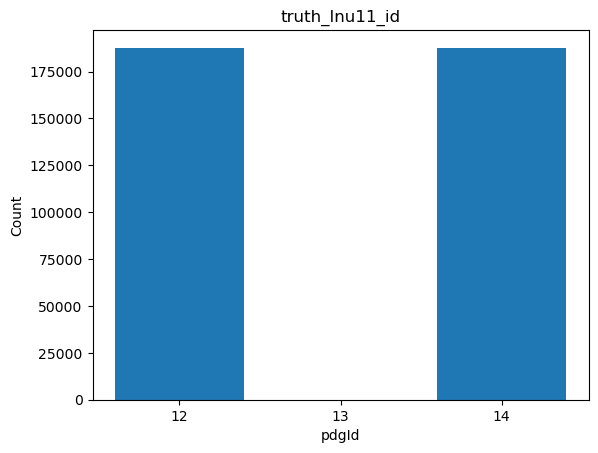

187486


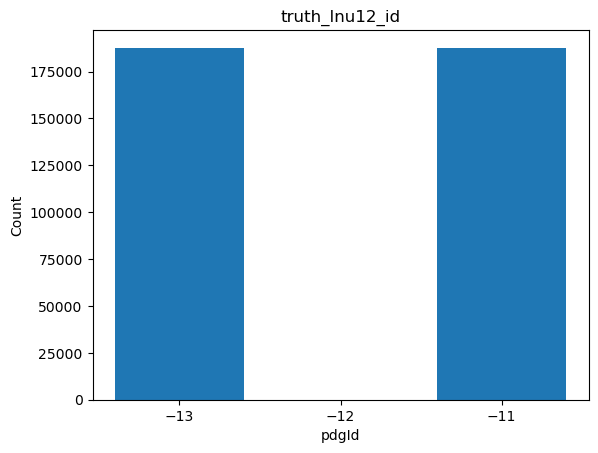

187486


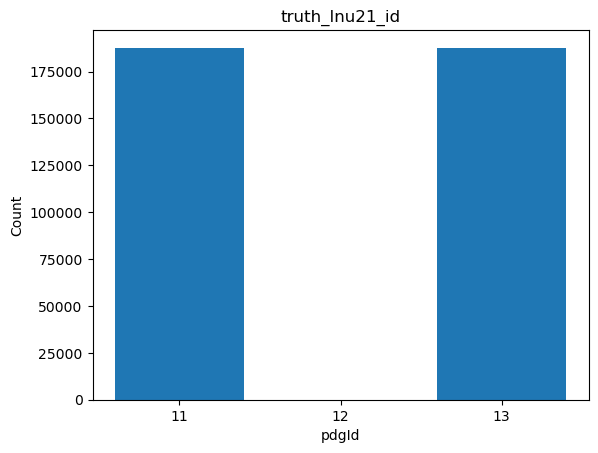

187486


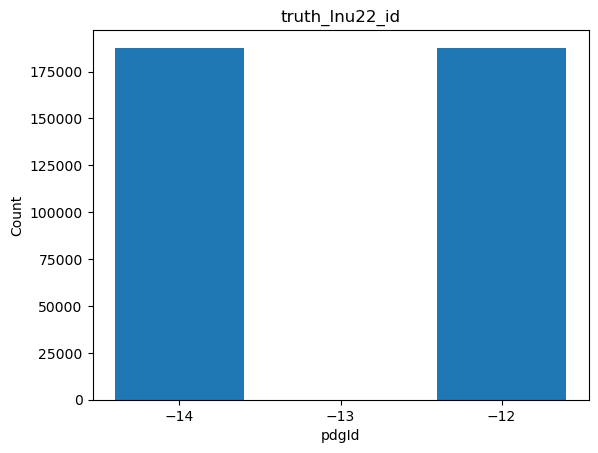

375170


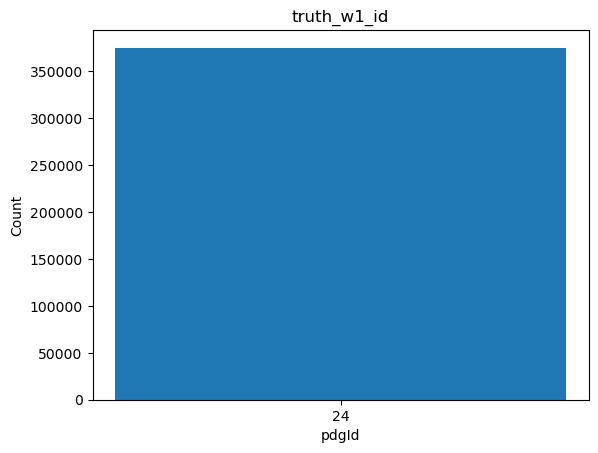

375170


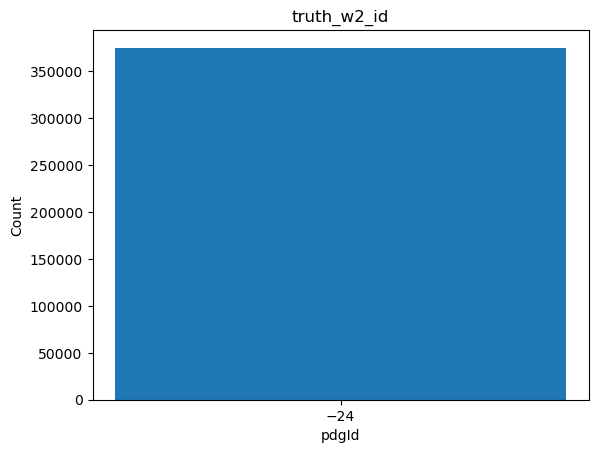

375170


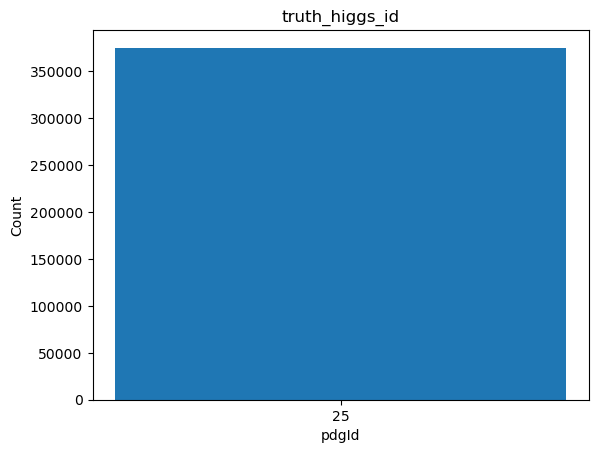

In [11]:
print(np.sum(truth_lnu11_id==12))
unique_ids, counts = np.unique(truth_lnu11_id, return_counts=True)
plt.bar(unique_ids, counts)
# plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdgId")
plt.ylabel("Count")
plt.title("truth_lnu11_id")
plt.show()

print(np.sum(truth_lnu12_id==-11))
unique_ids, counts = np.unique(truth_lnu12_id, return_counts=True)
plt.bar(unique_ids, counts)
# plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdgId")
plt.ylabel("Count")
plt.title("truth_lnu12_id")
plt.show()

print(np.sum(truth_lnu21_id==13))
unique_ids, counts = np.unique(truth_lnu21_id, return_counts=True)
plt.bar(unique_ids, counts)
# plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdgId")
plt.ylabel("Count")
plt.title("truth_lnu21_id")
plt.show()

print(np.sum(truth_lnu22_id==-14))
unique_ids, counts = np.unique(truth_lnu22_id, return_counts=True)
plt.bar(unique_ids, counts)
# plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdgId")
plt.ylabel("Count")
plt.title("truth_lnu22_id")
plt.show()

print(np.sum(truth_w1_id==24))
unique_ids, counts = np.unique(truth_w1_id, return_counts=True)
plt.bar(unique_ids, counts)
# plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdgId")
plt.ylabel("Count")
plt.title("truth_w1_id")
plt.show()

print(np.sum(truth_w2_id==-24))
unique_ids, counts = np.unique(truth_w2_id, return_counts=True)
plt.bar(unique_ids, counts)
# plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdgId")
plt.ylabel("Count")
plt.title("truth_w2_id")
plt.show()

print(np.sum(truth_higgs_id==25))
unique_ids, counts = np.unique(truth_higgs_id, return_counts=True)
plt.bar(unique_ids, counts)
# plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdgId")
plt.ylabel("Count")
plt.title("truth_higgs_id")
plt.show()

In [12]:
def is_valid(part1, part2, part11, part12, part21, part22):
    '''
    :params part1 : pdgId of the Hdecay1 --> W+
    :params part2 : pdgId of the Hdecay2 --> W-
    :params part11: pdgId of the particle 1 from Hdecay1 --> neutrino
    :params part12: pdgId of the particle 2 from Hdecay1 --> lepton
    :params part21: pdgId of the particle 1 from Hdecay2 --> lepton
    :params part22: pdgId of the particle 2 from Hdecay2 --> neutrino
    
    :return: boolean array of valid H->WW*->lvlv events
    '''
    cond1 = (part11 * part12 == -11*12) | (part11 * part12 == -13*14)  # pairing correct l and nu for part1
    cond2 = (part21 * part22 == -11*12) | (part21 * part22 == -13*14)  # pairing correct l and nu for part2
    cond3 = part12 * part21 == -11*13  # pairing diff flav leps and conserving charge (e, mu only)
    cond4 = part1 == 24   # confirm W+ boson (excluding zero paddings)
    cond5 = part2 == -24  # confirm W- boson (excluding zero paddings)
    # higgs has already been checked to be the correct particle ID form previous plots
    return cond1 & cond2 & cond3 & cond4 & cond5 

valid_ind = is_valid(truth_w1_id, truth_w2_id, truth_lnu11_id, truth_lnu12_id, truth_lnu21_id, truth_lnu22_id)
valid_car_ind = is_valid(truth_w1_id, truth_w2_id, truth_lnu11_car_id, truth_lnu12_car_id, truth_lnu21_car_id, truth_lnu22_car_id)
print("Check CAR results:", np.all(valid_ind == valid_car_ind))

print("Double check the valid indices...", "before", len(truth_w1_id[valid_ind]), "after", len(truth_w1_id[valid_ind]))
print("Ratio of double checking:", len(truth_w1_id[valid_ind]) / len(truth_w1_id))

Check CAR results: True
Double check the valid indices... before 375170 after 375170
Ratio of double checking: 1.0


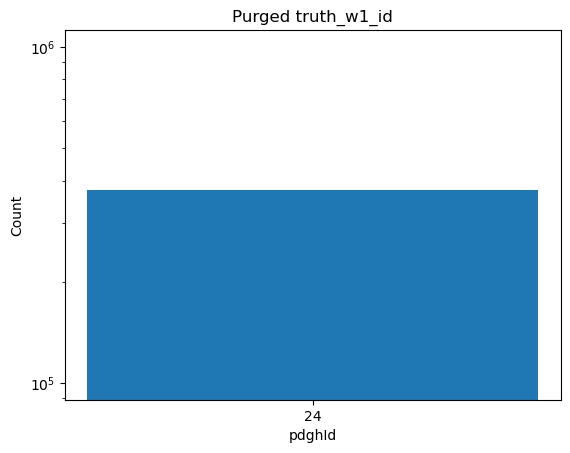

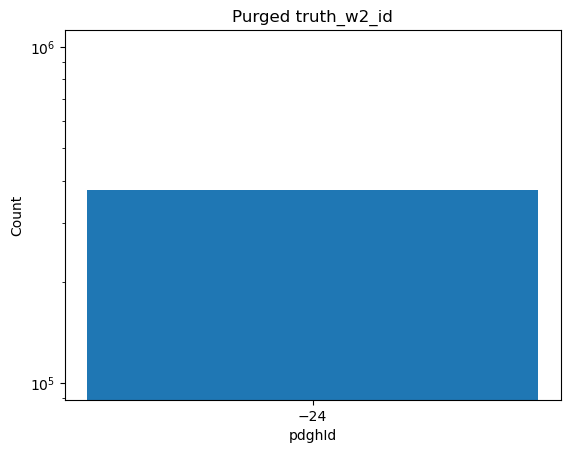

Two w boson need to have same length... (before double checking) True
Two w boson need to have same length... True


In [13]:
unique_ids, counts = np.unique(truth_w1_id[valid_ind], return_counts=True)
plt.bar(unique_ids, counts)
plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdghId")
plt.ylabel("Count")
plt.title("Purged truth_w1_id")
plt.show()

unique_ids, counts = np.unique(truth_w2_id[valid_ind], return_counts=True)
plt.bar(unique_ids, counts)
plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdghId")
plt.ylabel("Count")
plt.title("Purged truth_w2_id")
plt.show()

print(
    "Two w boson need to have same length... (before double checking)",
    np.all(len(truth_w1_id == len(truth_w2_id))),
)
print(
    "Two w boson need to have same length...",
    np.all(len(truth_w1_id[valid_ind] == len(truth_w2_id[valid_ind]))),
)

In [14]:
def test_plot(data, title, xlabel="[MeV]", ylabel="Count"):
    plt.figure(figsize=(12, 6))
    plt.hist(data, bins=np.linspace(data.min(), data.max(), 101))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    plt.close()

In [15]:
def px(pt, phi):
    return pt * np.cos(phi)

def py(pt, phi):
    return pt * np.sin(phi)

def pz(pt, eta):
    return pt * np.sinh(eta)

def energy(pt, eta, m):
    return np.sqrt(np.square(pt) + np.square(pz(pt, eta)) + np.square(m))

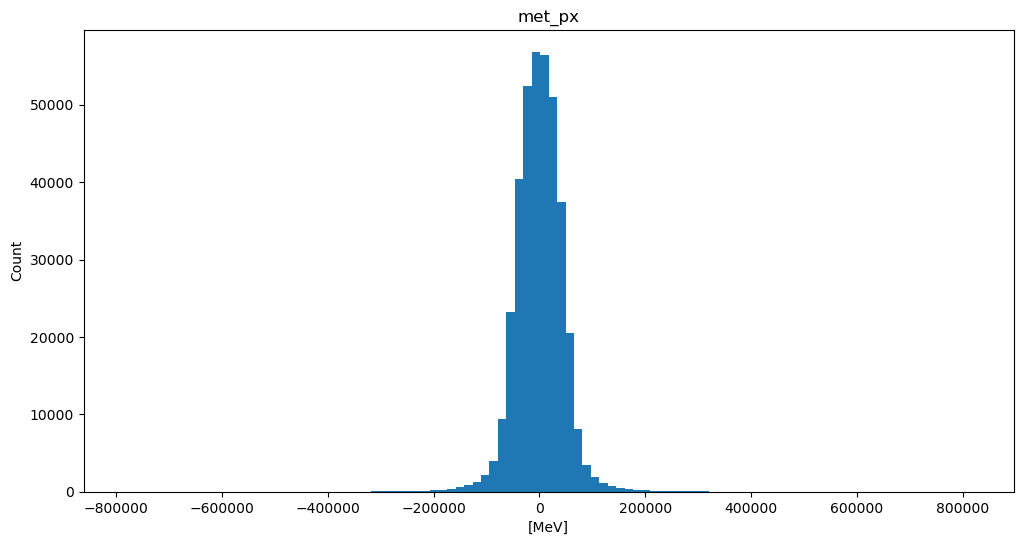

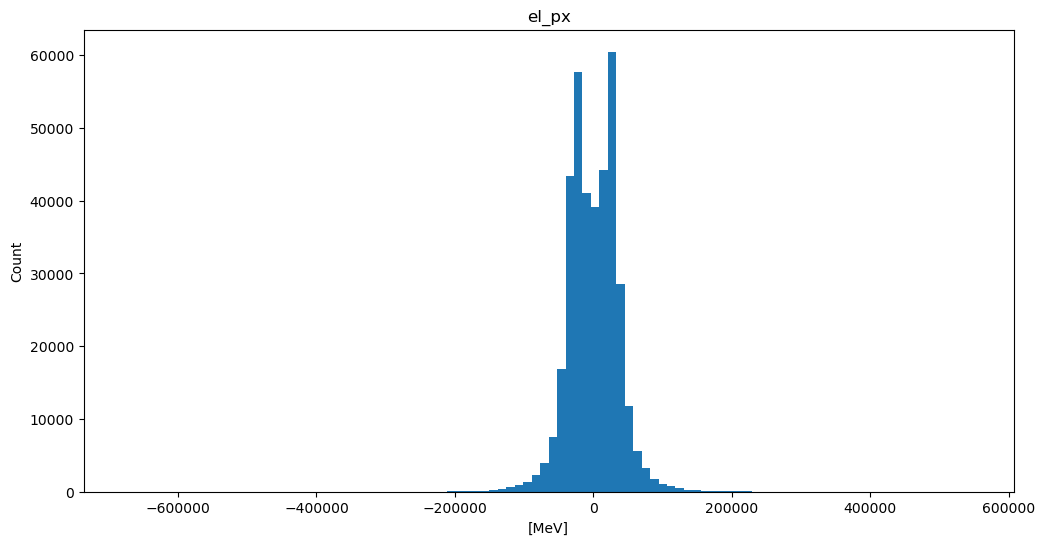

In [16]:
# reco lep

el_m = np.full(len(el_pt), 0.000511, dtype=np.float32)
mu_m = np.full(len(mu_pt), 0.105658, dtype=np.float32)

el_px = px(el_pt, el_phi)
el_py = py(el_pt, el_phi)
el_pz = pz(el_pt, el_eta)
el_e = energy(el_pt, el_eta, el_m)
mu_px = px(mu_pt, mu_phi)
mu_py = py(mu_pt, mu_phi)
mu_pz = pz(mu_pt, mu_eta)
mu_e = energy(mu_pt, mu_eta, mu_m)
met_px = px(met_pt, met_phi)
met_py = py(met_pt, met_phi)
test_plot(met_px, "met_px")
test_plot(el_px, "el_px")

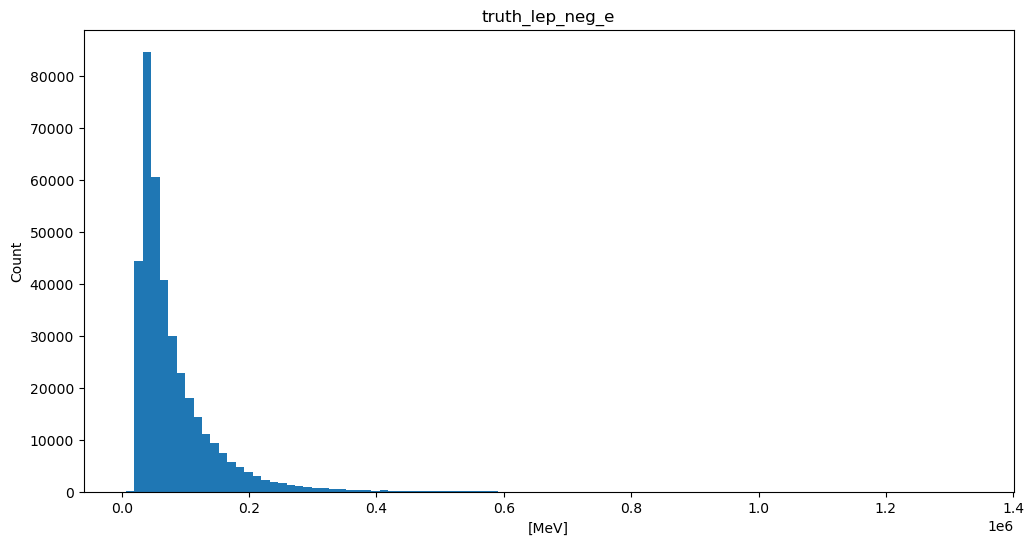

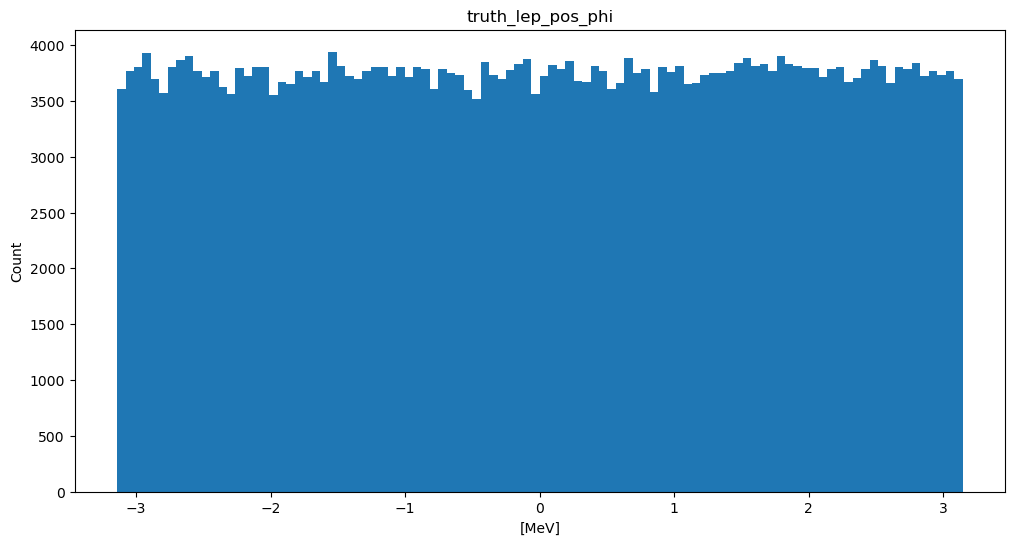

In [17]:
# truth lep

truth_nu_pos_pt = truth_lnu11_pt[valid_ind]
truth_lep_neg_pt = truth_lnu12_pt[valid_ind]
truth_lep_pos_pt = truth_lnu21_pt[valid_ind]
truth_nu_neg_pt = truth_lnu22_pt[valid_ind]
# test_plot(truth_nu_pos_pt, 'truth_nu_pos_pt')
# test_plot(truth_lep_neg_pt, 'truth_lep_neg_pt')

truth_nu_pos_eta = truth_lnu11_eta[valid_ind]
truth_lep_neg_eta = truth_lnu12_eta[valid_ind]
truth_lep_pos_eta = truth_lnu21_eta[valid_ind]
truth_nu_neg_eta = truth_lnu22_eta[valid_ind]

truth_nu_pos_phi = truth_lnu11_phi[valid_ind]
truth_lep_neg_phi = truth_lnu12_phi[valid_ind]
truth_lep_pos_phi = truth_lnu21_phi[valid_ind]
truth_nu_neg_phi = truth_lnu22_phi[valid_ind]

truth_nu_pos_m = np.zeros(truth_nu_pos_phi.shape)
lep_neg_m = np.full(len(truth_nu_pos_m), -999, dtype=np.float32)
mask_electron = truth_lnu12_id[valid_ind] == -11
mask_muon = truth_lnu12_id[valid_ind] == -13
lep_neg_m[mask_electron] = 0.000511
lep_neg_m[mask_muon] = 0.105658
if not np.all(mask_muon | mask_electron):
    print("Error: lep_neg_id is not lepton")
lep_pos_m = np.full(len(truth_nu_pos_phi), -999, dtype=np.float32)
mask_electron = truth_lnu21_id[valid_ind] == 11
mask_muon = truth_lnu21_id[valid_ind] == 13
lep_pos_m[mask_electron] = 0.000511
lep_pos_m[mask_muon] = 0.105658
if not np.all(mask_muon | mask_electron):
    print("Error: lep_pos_id is not lepton")
truth_nu_neg_m = np.zeros(truth_nu_neg_phi.shape)

truth_nu_pos_px = px(truth_nu_pos_pt, truth_nu_pos_phi)
truth_nu_pos_py = py(truth_nu_pos_pt, truth_nu_pos_phi)
truth_nu_pos_pz = pz(truth_nu_pos_pt, truth_nu_pos_eta)
truth_nu_pos_e = energy(truth_nu_pos_pt, truth_nu_pos_eta, truth_nu_pos_m)
truth_nu_neg_px = px(truth_nu_neg_pt, truth_nu_neg_phi)
truth_nu_neg_py = py(truth_nu_neg_pt, truth_nu_neg_phi)
truth_nu_neg_pz = pz(truth_nu_neg_pt, truth_nu_neg_eta)
truth_nu_neg_e = energy(truth_nu_neg_pt, truth_nu_neg_eta, truth_nu_neg_m)
truth_lep_pos_px = px(truth_lep_pos_pt, truth_lep_pos_phi)
truth_lep_pos_py = py(truth_lep_pos_pt, truth_lep_pos_phi)
truth_lep_pos_pz = pz(truth_lep_pos_pt, truth_lep_pos_eta)
truth_lep_pos_e = energy(truth_lep_pos_pt, truth_lep_pos_eta, lep_pos_m)
truth_lep_neg_px = px(truth_lep_neg_pt, truth_lep_neg_phi)
truth_lep_neg_py = py(truth_lep_neg_pt, truth_lep_neg_phi)
truth_lep_neg_pz = pz(truth_lep_neg_pt, truth_lep_neg_eta)
truth_lep_neg_e = energy(truth_lep_neg_pt, truth_lep_neg_eta, lep_neg_m)
test_plot(truth_lep_neg_e, "truth_lep_neg_e")
test_plot(truth_lep_pos_phi, "truth_lep_pos_phi")

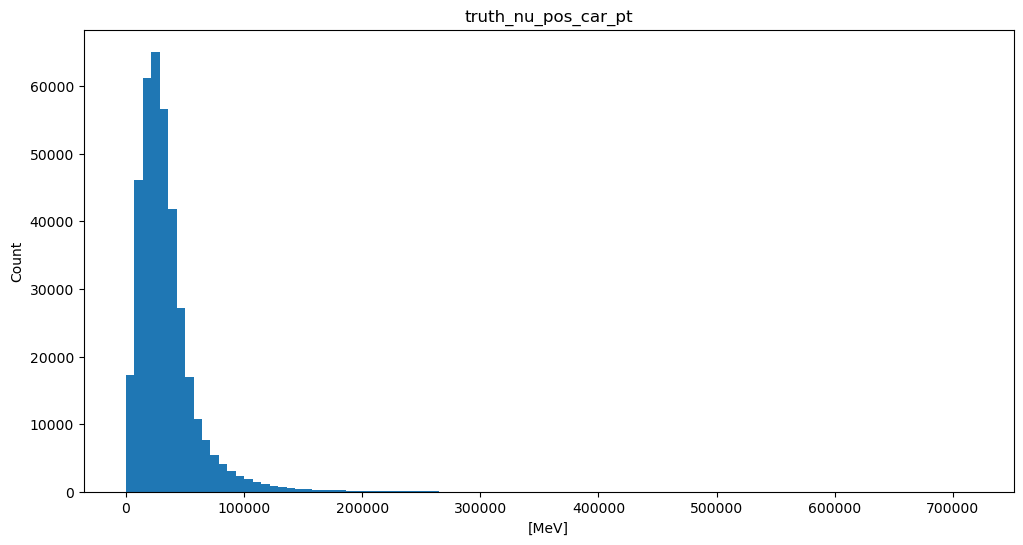

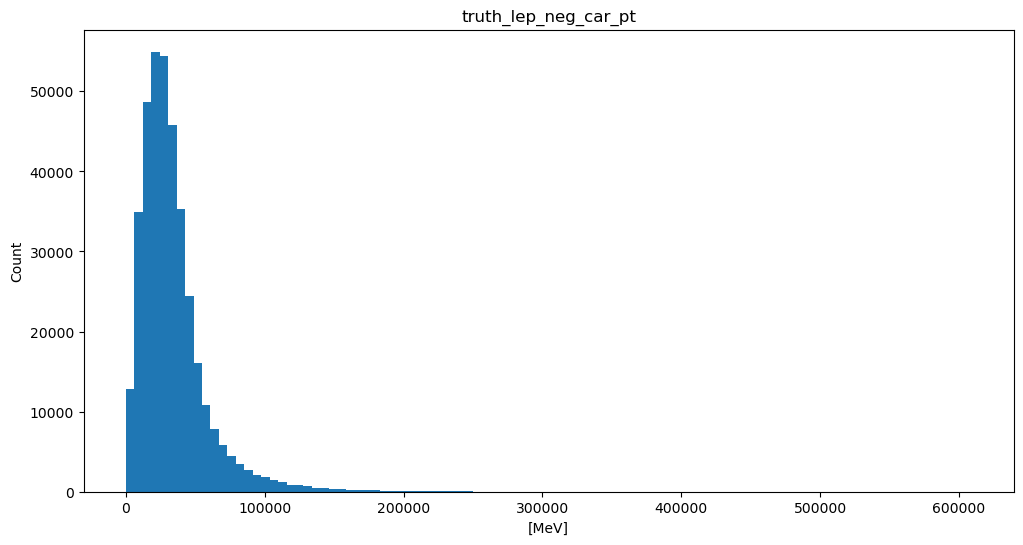

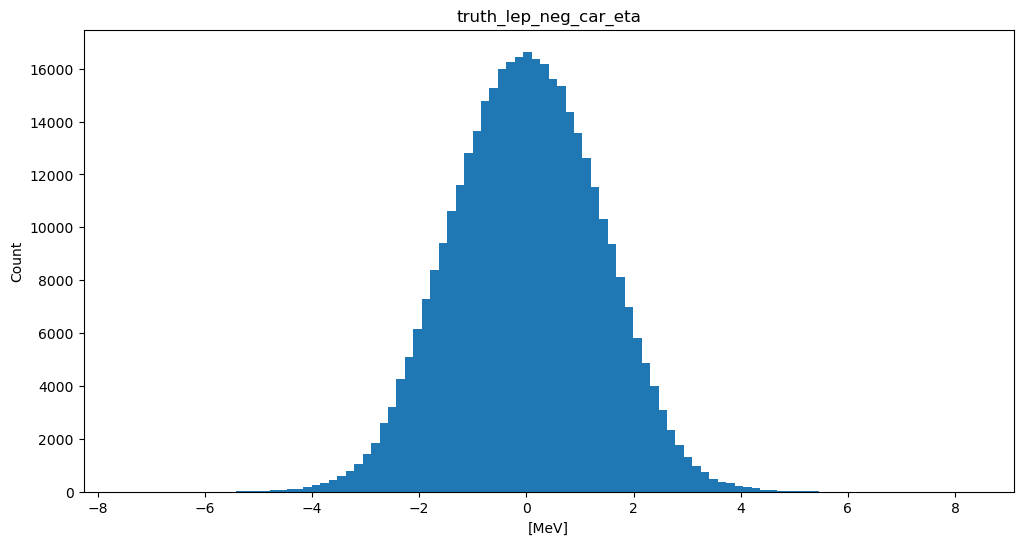

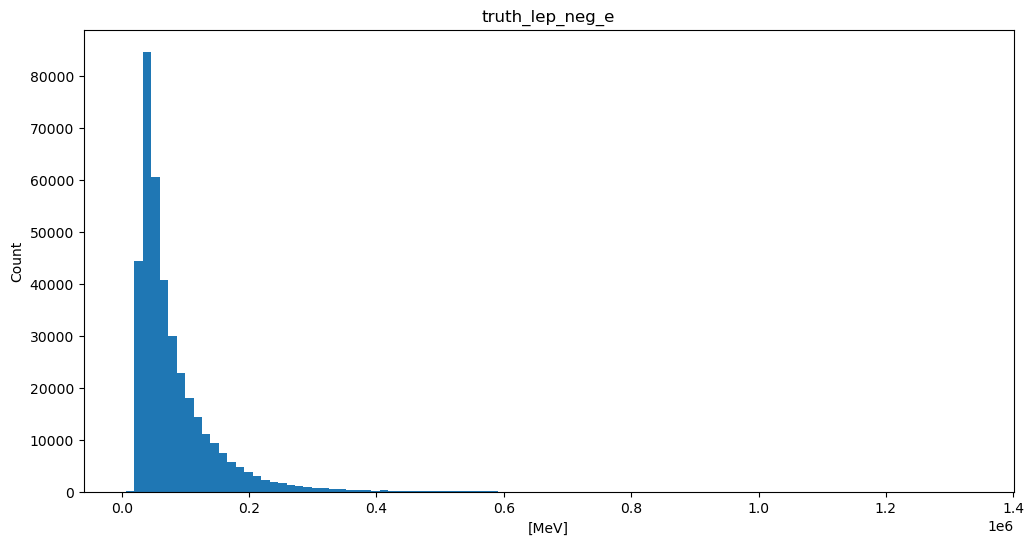

In [18]:
# truth lep (CAR)

truth_nu_pos_car_pt = truth_lnu11_car_pt[valid_ind]
truth_lep_neg_car_pt = truth_lnu12_car_pt[valid_ind]
truth_lep_pos_car_pt = truth_lnu21_car_pt[valid_ind]
truth_nu_neg_car_pt = truth_lnu22_car_pt[valid_ind]
test_plot(truth_nu_pos_car_pt, "truth_nu_pos_car_pt")
test_plot(truth_lep_neg_car_pt, "truth_lep_neg_car_pt")

truth_nu_pos_car_eta = truth_lnu11_car_eta[valid_ind]
truth_lep_neg_car_eta = truth_lnu12_car_eta[valid_ind]
truth_lep_pos_car_eta = truth_lnu21_car_eta[valid_ind]
truth_nu_neg_car_eta = truth_lnu22_car_eta[valid_ind]
test_plot(truth_lep_neg_car_eta, "truth_lep_neg_car_eta")


truth_nu_pos_car_phi = truth_lnu11_car_phi[valid_ind]
truth_lep_neg_car_phi = truth_lnu12_car_phi[valid_ind]
truth_lep_pos_car_phi = truth_lnu21_car_phi[valid_ind]
truth_nu_neg_car_phi = truth_lnu22_car_phi[valid_ind]

truth_nu_pos_car_m = np.zeros(truth_nu_pos_car_phi.shape)
lep_neg_car_m = np.full(len(truth_nu_pos_car_phi), -999, dtype=np.float32)
mask_electron = truth_lnu12_id[valid_ind] == -11
mask_muon = truth_lnu12_id[valid_ind] == -13
lep_neg_car_m[mask_electron] = 0.000511
lep_neg_car_m[mask_muon] = 0.105658
if not np.all(mask_muon | mask_electron):
    print("Error: lep_neg_id is not lepton")
lep_pos_car_m = np.full(len(truth_nu_pos_car_phi), -999, dtype=np.float32)
mask_electron = truth_lnu21_id[valid_ind] == 11
mask_muon = truth_lnu21_id[valid_ind] == 13
lep_pos_car_m[mask_electron] = 0.000511
lep_pos_car_m[mask_muon] = 0.105658
if not np.all(mask_muon | mask_electron):
    print("Error: lep_pos_id is not lepton")
truth_nu_neg_car_m = np.zeros(truth_nu_neg_car_phi.shape)

truth_nu_pos_car_px = px(truth_nu_pos_car_pt, truth_nu_pos_car_phi)
truth_nu_pos_car_py = py(truth_nu_pos_car_pt, truth_nu_pos_car_phi)
truth_nu_pos_car_pz = pz(truth_nu_pos_car_pt, truth_nu_pos_car_eta)
truth_nu_pos_car_e = energy(
    truth_nu_pos_car_pt, truth_nu_pos_car_eta, truth_nu_pos_car_m
)
truth_nu_neg_car_px = px(truth_nu_neg_car_pt, truth_nu_neg_car_phi)
truth_nu_neg_car_py = py(truth_nu_neg_car_pt, truth_nu_neg_car_phi)
truth_nu_neg_car_pz = pz(truth_nu_neg_car_pt, truth_nu_neg_car_eta)
truth_nu_neg_car_e = energy(
    truth_nu_neg_car_pt, truth_nu_neg_car_eta, truth_nu_neg_car_m
)
truth_lep_pos_car_px = px(truth_lep_pos_car_pt, truth_lep_pos_car_phi)
truth_lep_pos_car_py = py(truth_lep_pos_car_pt, truth_lep_pos_car_phi)
truth_lep_pos_car_pz = pz(truth_lep_pos_car_pt, truth_lep_pos_car_eta)
truth_lep_pos_car_e = energy(truth_lep_pos_car_pt, truth_lep_pos_car_eta, lep_pos_car_m)
truth_lep_neg_car_px = px(truth_lep_neg_car_pt, truth_lep_neg_car_phi)
truth_lep_neg_car_py = py(truth_lep_neg_car_pt, truth_lep_neg_car_phi)
truth_lep_neg_car_pz = pz(truth_lep_neg_car_pt, truth_lep_neg_car_eta)
truth_lep_neg_car_e = energy(truth_lep_neg_car_pt, truth_lep_neg_car_eta, lep_neg_car_m)
test_plot(truth_lep_neg_e, "truth_lep_neg_e")

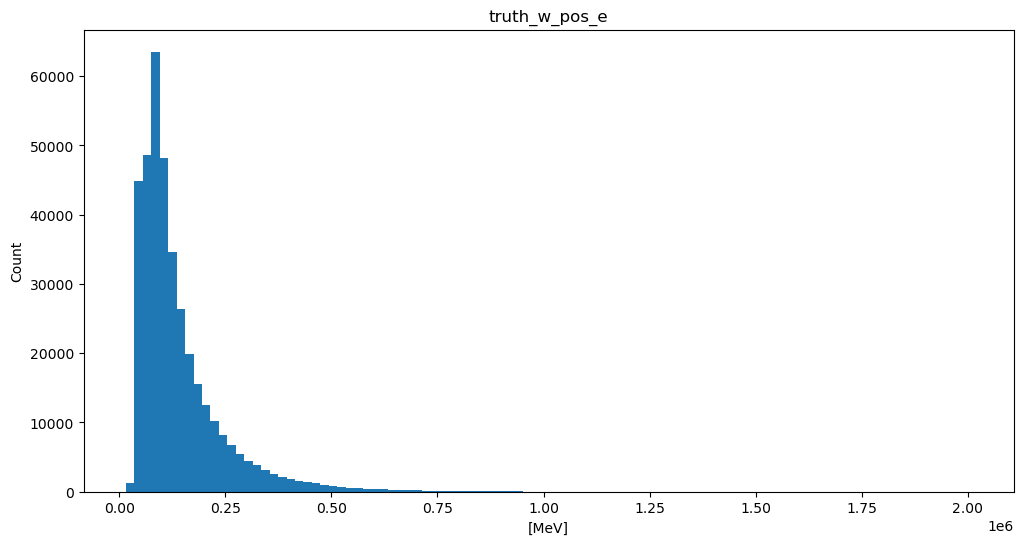

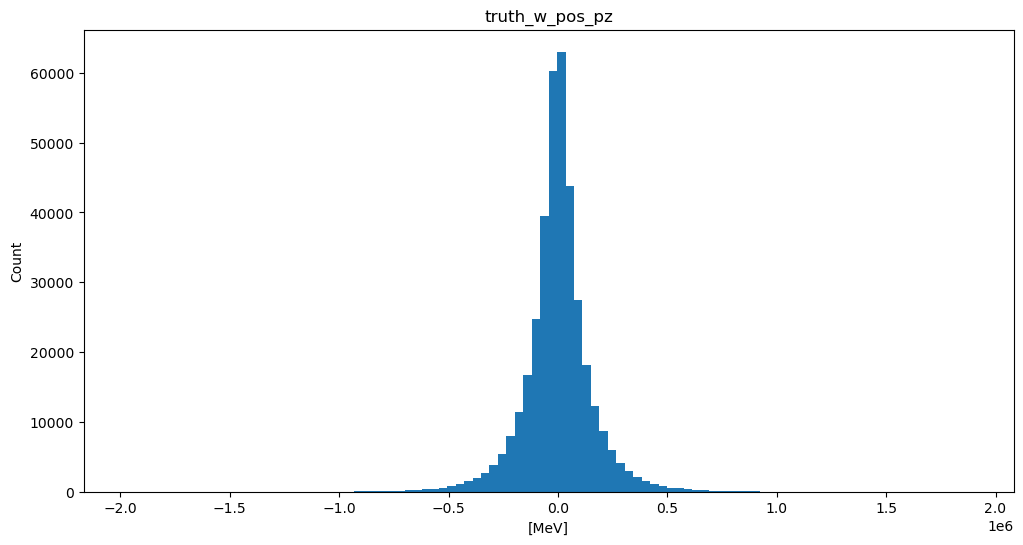

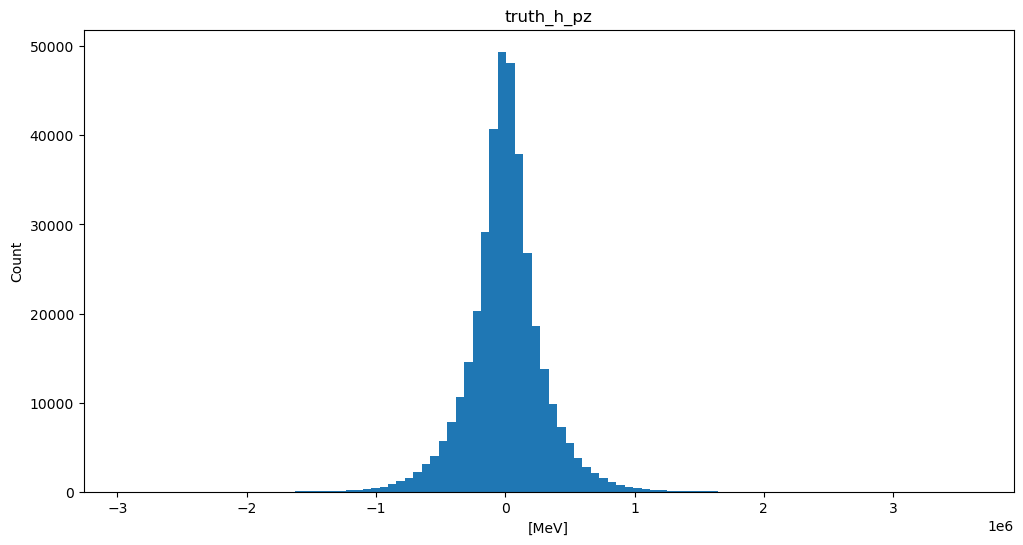

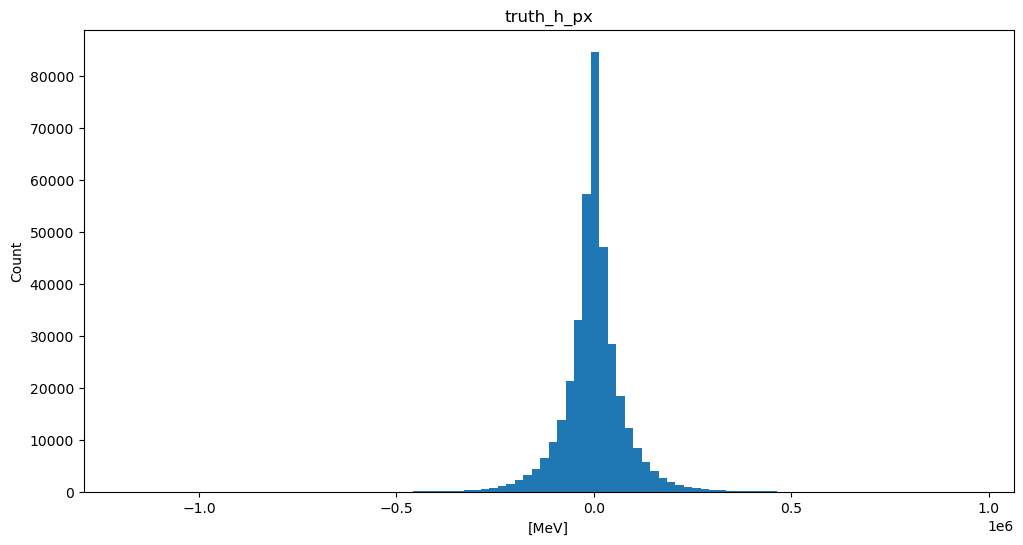

In [19]:
# truth w

truth_w_neg = truth_w1_id[valid_ind]
truth_w_neg_pt = truth_w1_pt[valid_ind]
truth_w_neg_eta = truth_w1_eta[valid_ind]
truth_w_neg_phi = truth_w1_phi[valid_ind]
truth_w_neg_m = truth_w1_m[valid_ind]
# test_plot(truth_w_neg_m, 'truth_w_neg_m')

truth_w_pos = truth_w2_id[valid_ind]
truth_w_pos_pt = truth_w2_pt[valid_ind]
truth_w_pos_eta = truth_w2_eta[valid_ind]
truth_w_pos_phi = truth_w2_phi[valid_ind]
truth_w_pos_m = truth_w2_m[valid_ind]
# test_plot(truth_w_pos_m, 'truth_w_pos_m')

truth_w_neg_px = px(truth_w_neg_pt, truth_w_neg_phi)
truth_w_neg_py = py(truth_w_neg_pt, truth_w_neg_phi)
truth_w_neg_pz = pz(truth_w_neg_pt, truth_w_neg_eta)
truth_w_neg_e = energy(truth_w_neg_pt, truth_w_neg_eta, truth_w_neg_m)
truth_w_pos_px = px(truth_w_pos_pt, truth_w_pos_phi)
truth_w_pos_py = py(truth_w_pos_pt, truth_w_pos_phi)
truth_w_pos_pz = pz(truth_w_pos_pt, truth_w_pos_eta)
truth_w_pos_e = energy(truth_w_pos_pt, truth_w_pos_eta, truth_w_pos_m)
test_plot(truth_w_pos_e, "truth_w_pos_e")
test_plot(truth_w_pos_pz, "truth_w_pos_pz")

# truth h
truth_h_pt = truth_higgs_pt[valid_ind]
truth_h_eta = truth_higgs_eta[valid_ind]
truth_h_phi = truth_higgs_phi[valid_ind]
truth_h_m = truth_higgs_m[valid_ind]
# test_plot(truth_h_m, 'truth_h_m')

truth_h_px = px(truth_h_pt, truth_h_phi)
truth_h_py = py(truth_h_pt, truth_h_phi)
truth_h_pz = pz(truth_h_pt, truth_h_eta)
truth_h_e = energy(truth_h_pt, truth_h_eta, truth_h_m)
test_plot(truth_h_pz, "truth_h_pz")
test_plot(truth_h_px, "truth_h_px")

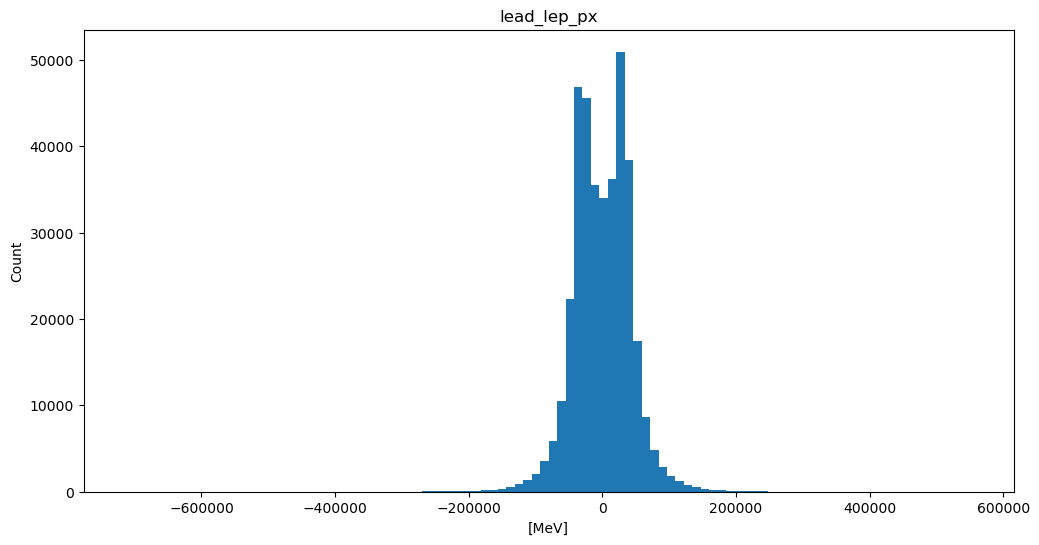

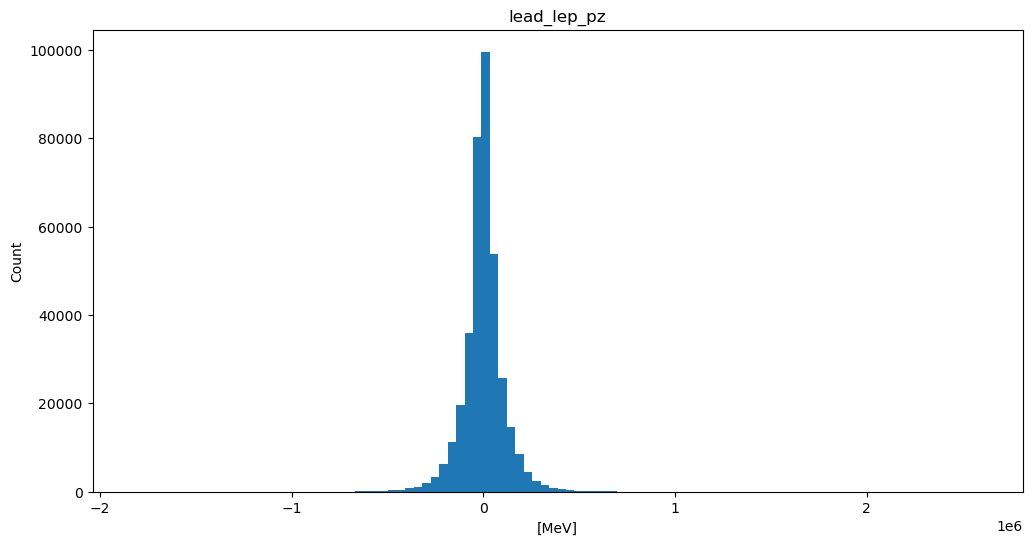

In [20]:
# (sub)lead identification (reco)

el_leading_mask = el_pt >= mu_pt

lead_lep_px = np.where(el_leading_mask, el_px, mu_px)
lead_lep_py = np.where(el_leading_mask, el_py, mu_py)
lead_lep_pz = np.where(el_leading_mask, el_pz, mu_pz)
lead_lep_e = np.where(el_leading_mask, el_e, mu_e)
test_plot(lead_lep_px, "lead_lep_px")
test_plot(lead_lep_pz, "lead_lep_pz")

sublead_lep_px = np.where(el_leading_mask, mu_px, el_px)
sublead_lep_py = np.where(el_leading_mask, mu_py, el_py)
sublead_lep_pz = np.where(el_leading_mask, mu_pz, el_pz)
sublead_lep_e = np.where(el_leading_mask, mu_e, el_e)

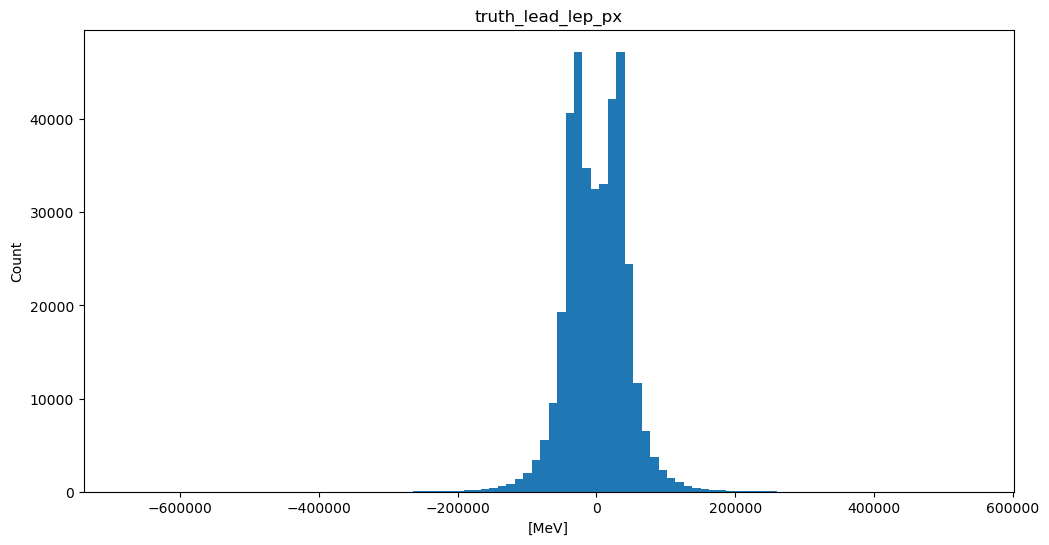

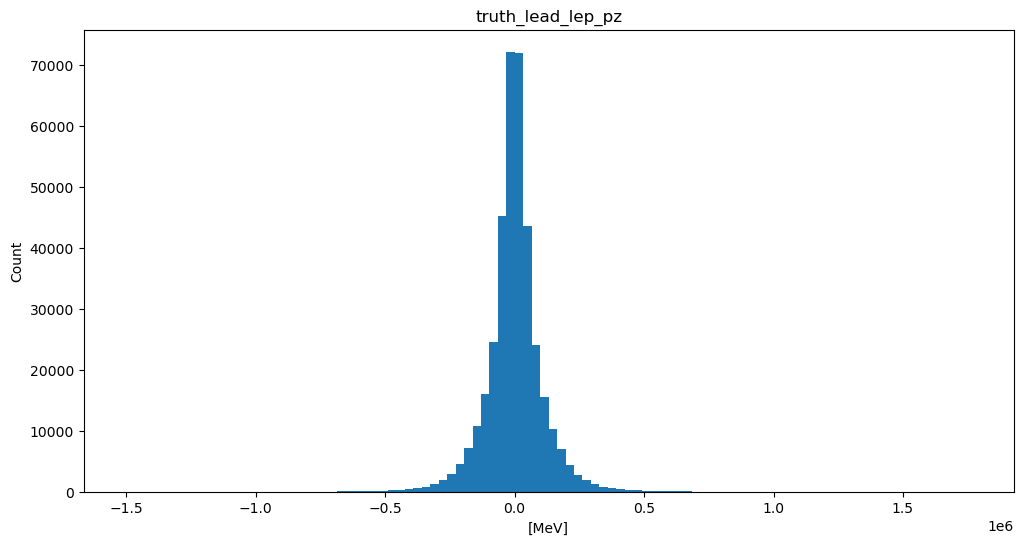

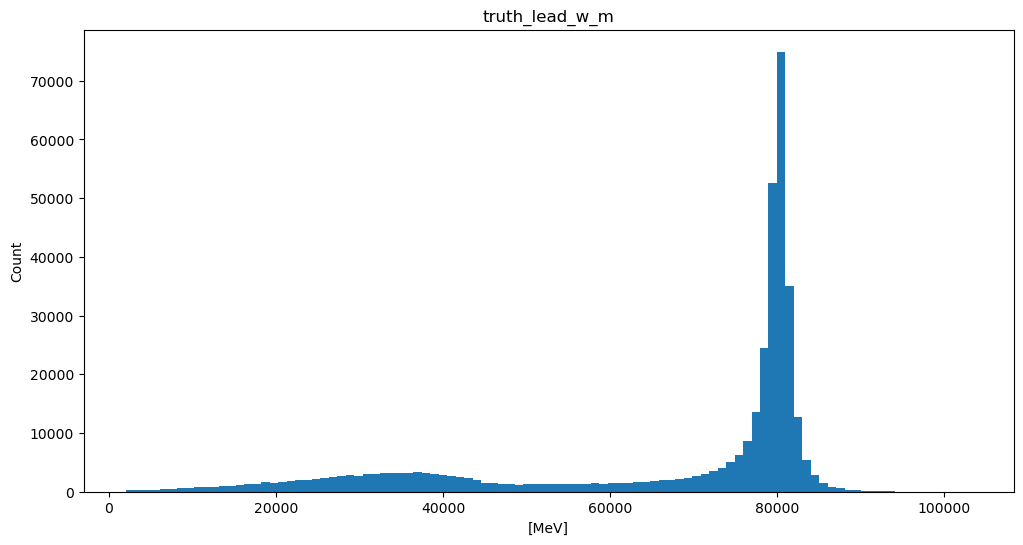

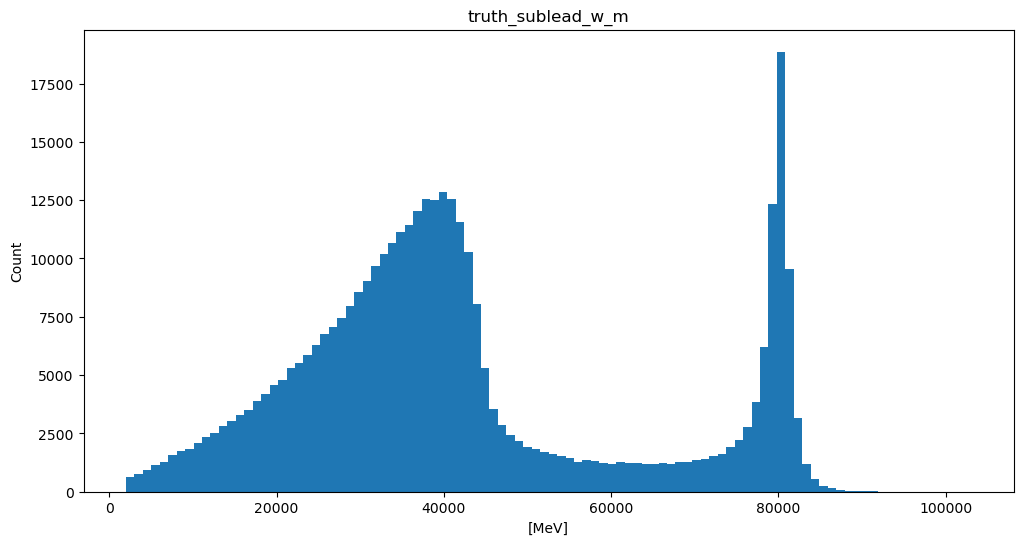

In [21]:
# (sub)lead identification (truth)

neg_leading_mask = truth_lep_neg_pt >= truth_lep_pos_pt

truth_lead_lep_px = np.where(neg_leading_mask, truth_lep_neg_px, truth_lep_pos_px)
truth_lead_lep_py = np.where(neg_leading_mask, truth_lep_neg_py, truth_lep_pos_py)
truth_lead_lep_pz = np.where(neg_leading_mask, truth_lep_neg_pz, truth_lep_pos_pz)
truth_lead_lep_e = np.where(neg_leading_mask, truth_lep_neg_e, truth_lep_pos_e)
test_plot(truth_lead_lep_px, "truth_lead_lep_px")
test_plot(truth_lead_lep_pz, "truth_lead_lep_pz")

truth_sublead_lep_px = np.where(neg_leading_mask, truth_lep_pos_px, truth_lep_neg_px)
truth_sublead_lep_py = np.where(neg_leading_mask, truth_lep_pos_py, truth_lep_neg_py)
truth_sublead_lep_pz = np.where(neg_leading_mask, truth_lep_pos_pz, truth_lep_neg_pz)
truth_sublead_lep_e = np.where(neg_leading_mask, truth_lep_pos_e, truth_lep_neg_e)

truth_lead_nu_px = np.where(neg_leading_mask, truth_nu_neg_px, truth_nu_pos_px)
truth_lead_nu_py = np.where(neg_leading_mask, truth_nu_neg_py, truth_nu_pos_py)
truth_lead_nu_pz = np.where(neg_leading_mask, truth_nu_neg_pz, truth_nu_pos_pz)
truth_lead_nu_e = np.where(neg_leading_mask, truth_nu_neg_e, truth_nu_pos_e)

truth_sublead_nu_px = np.where(neg_leading_mask, truth_nu_pos_px, truth_nu_neg_px)
truth_sublead_nu_py = np.where(neg_leading_mask, truth_nu_pos_py, truth_nu_neg_py)
truth_sublead_nu_pz = np.where(neg_leading_mask, truth_nu_pos_pz, truth_nu_neg_pz)
truth_sublead_nu_e = np.where(neg_leading_mask, truth_nu_pos_e, truth_nu_neg_e)

truth_lead_w_px = np.where(neg_leading_mask, truth_w_neg_px, truth_w_pos_px)
truth_lead_w_py = np.where(neg_leading_mask, truth_w_neg_py, truth_w_pos_py)
truth_lead_w_pz = np.where(neg_leading_mask, truth_w_neg_pz, truth_w_pos_pz)
truth_lead_w_e = np.where(neg_leading_mask, truth_w_neg_e, truth_w_pos_e)
truth_lead_w_m = np.where(neg_leading_mask, truth_w_neg_m, truth_w_pos_m)

truth_sublead_w_px = np.where(neg_leading_mask, truth_w_pos_px, truth_w_neg_px)
truth_sublead_w_py = np.where(neg_leading_mask, truth_w_pos_py, truth_w_neg_py)
truth_sublead_w_pz = np.where(neg_leading_mask, truth_w_pos_pz, truth_w_neg_pz)
truth_sublead_w_e = np.where(neg_leading_mask, truth_w_pos_e, truth_w_neg_e)
truth_sublead_w_m = np.where(neg_leading_mask, truth_w_pos_m, truth_w_neg_m)
test_plot(truth_lead_w_m, "truth_lead_w_m")
test_plot(truth_sublead_w_m, "truth_sublead_w_m")

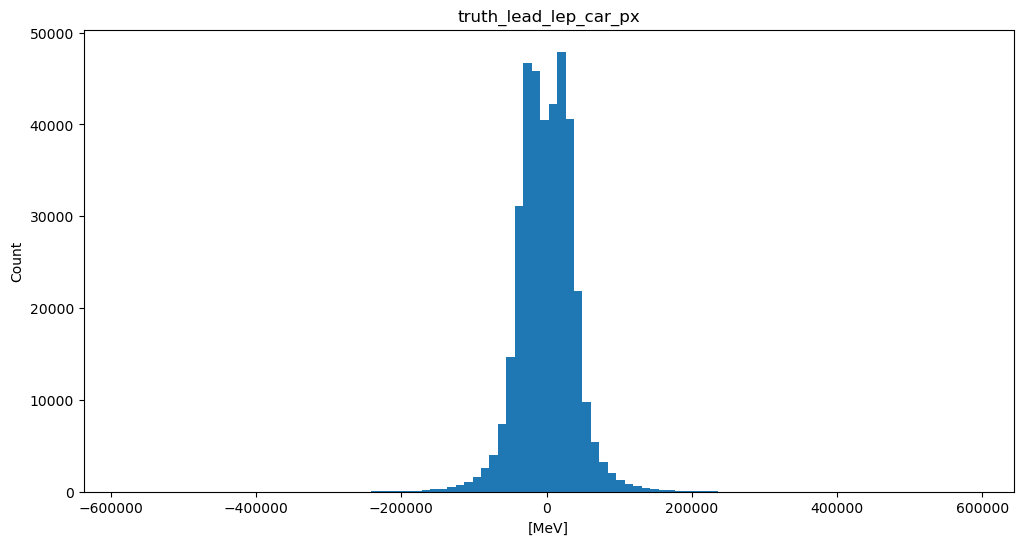

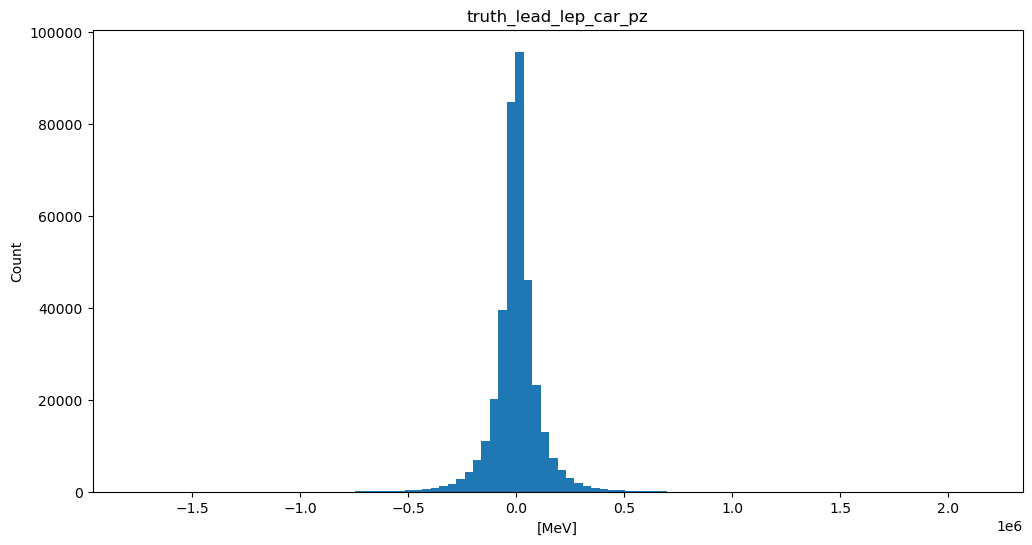

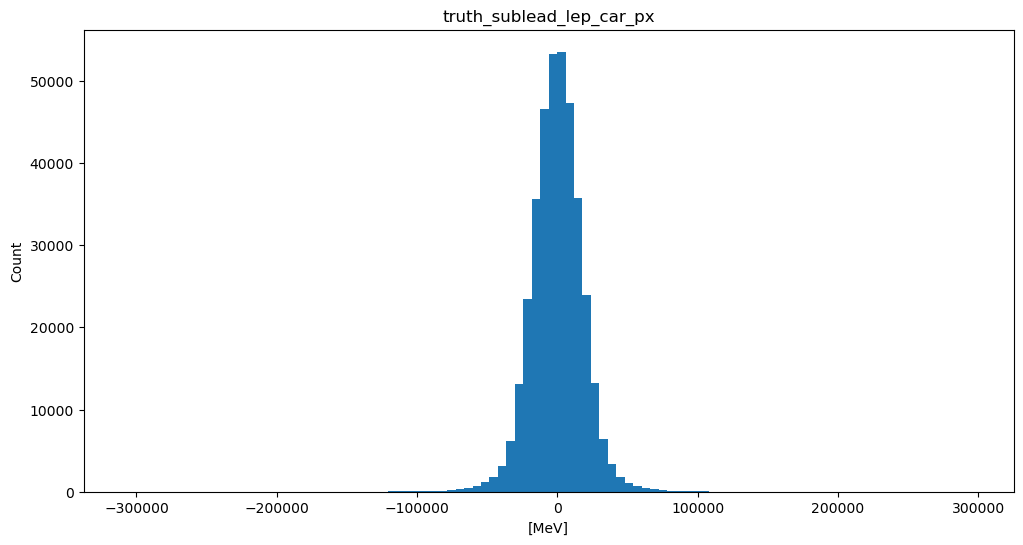

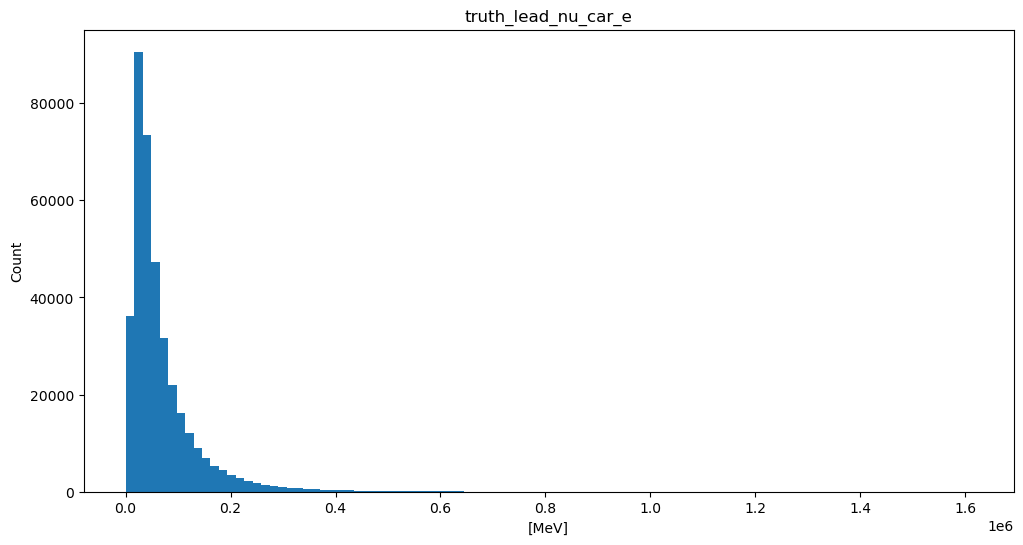

In [22]:
# (sub)lead identification (truth_CAR)

neg_leading_car_mask = truth_lep_neg_car_pt >= truth_lep_pos_car_pt

truth_lead_lep_car_px = np.where(
    neg_leading_car_mask, truth_lep_neg_car_px, truth_lep_pos_car_px
)
truth_lead_lep_car_py = np.where(
    neg_leading_car_mask, truth_lep_neg_car_py, truth_lep_pos_car_py
)
truth_lead_lep_car_pz = np.where(
    neg_leading_car_mask, truth_lep_neg_car_pz, truth_lep_pos_car_pz
)
truth_lead_lep_car_e = np.where(
    neg_leading_car_mask, truth_lep_neg_car_e, truth_lep_pos_car_e
)
test_plot(truth_lead_lep_car_px, "truth_lead_lep_car_px")
test_plot(truth_lead_lep_car_pz, "truth_lead_lep_car_pz")

truth_sublead_lep_car_px = np.where(
    neg_leading_car_mask, truth_lep_pos_car_px, truth_lep_neg_car_px
)
truth_sublead_lep_car_py = np.where(
    neg_leading_car_mask, truth_lep_pos_car_py, truth_lep_neg_car_py
)
truth_sublead_lep_car_pz = np.where(
    neg_leading_car_mask, truth_lep_pos_car_pz, truth_lep_neg_car_pz
)
truth_sublead_lep_car_e = np.where(
    neg_leading_car_mask, truth_lep_pos_car_e, truth_lep_neg_car_e
)
test_plot(truth_sublead_lep_car_px, "truth_sublead_lep_car_px")

truth_lead_nu_car_px = np.where(
    neg_leading_car_mask, truth_nu_neg_car_px, truth_nu_pos_car_px
)
truth_lead_nu_car_py = np.where(
    neg_leading_car_mask, truth_nu_neg_car_py, truth_nu_pos_car_py
)
truth_lead_nu_car_pz = np.where(
    neg_leading_car_mask, truth_nu_neg_car_pz, truth_nu_pos_car_pz
)
truth_lead_nu_car_e = np.where(
    neg_leading_car_mask, truth_nu_neg_car_e, truth_nu_pos_car_e
)

truth_sublead_nu_car_px = np.where(
    neg_leading_car_mask, truth_nu_pos_car_px, truth_nu_neg_car_px
)
truth_sublead_nu_car_py = np.where(
    neg_leading_car_mask, truth_nu_pos_car_py, truth_nu_neg_car_py
)
truth_sublead_nu_car_pz = np.where(
    neg_leading_car_mask, truth_nu_pos_car_pz, truth_nu_neg_car_pz
)
truth_sublead_nu_car_e = np.where(
    neg_leading_car_mask, truth_nu_pos_car_e, truth_nu_neg_car_e
)

test_plot(truth_lead_nu_car_e, "truth_lead_nu_car_e")

In [23]:
GEV = 1e-3

def pt(px, py):
    return np.sqrt(np.square(px) + np.square(py))


def eta(px, py, pz):
    pt = np.sqrt(np.square(px) + np.square(py))
    return np.arcsinh(np.divide(pz, pt))


def phi(px, py):
    return np.arctan2(py, px)


def deta(eta1, eta2):
    return np.abs(eta1 - eta2)


def dphi_pi(phi1, phi2):
    phi_diff = phi1 - phi2
    phi_diff = np.where(phi_diff < 0.0, -phi_diff, phi_diff)
    phi_diff = np.where(phi_diff > 2.0 * np.pi, phi_diff - 2.0 * np.pi, phi_diff)
    phi_diff = np.where(phi_diff >= np.pi, 2.0 * np.pi - phi_diff, phi_diff)
    return np.divide(phi_diff, np.pi)


def m(p4):
    return np.sqrt(
        np.square(p4[:, 3])
        - np.square(p4[:, 0])
        - np.square(p4[:, 1])
        - np.square(p4[:, 2])
    )


@dataclass
class Lead_lep:
    px = lead_lep_px * GEV
    py = lead_lep_py * GEV
    pz = lead_lep_pz * GEV
    energy = lead_lep_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Sublead_lep:
    px = sublead_lep_px * GEV
    py = sublead_lep_py * GEV
    pz = sublead_lep_pz * GEV
    energy = sublead_lep_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Dilep:
    p4 = Lead_lep.p4 + Sublead_lep.p4
    p3 = p4[:, :3]
    px = p4[:, 0]
    py = p4[:, 1]
    pz = p4[:, 2]
    dphi = dphi_pi(
        phi(Lead_lep.px, Lead_lep.py),
        phi(Sublead_lep.px, Sublead_lep.py)
    )
    deta = deta(
        eta(Lead_lep.px, Lead_lep.py, Lead_lep.pz),
        eta(Sublead_lep.px, Sublead_lep.py, Sublead_lep.pz)
    )
    m = m(p4)


@dataclass
class Met:
    px = met_px * GEV
    py = met_py * GEV
    pt = met_pt * GEV
    phi = met_phi
    

@dataclass
class Truth_lead_lep:
    px = truth_lead_lep_px * GEV
    py = truth_lead_lep_py * GEV
    pz = truth_lead_lep_pz * GEV
    energy = truth_lead_lep_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Truth_sublead_lep:
    px = truth_sublead_lep_px * GEV
    py = truth_sublead_lep_py * GEV
    pz = truth_sublead_lep_pz * GEV
    energy = truth_sublead_lep_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Truth_dilep:
    p4 = Truth_lead_lep.p4 + Truth_sublead_lep.p4
    p3 = p4[:, :3]
    px = p4[:, 0]
    py = p4[:, 1]
    pz = p4[:, 2]
    dphi = dphi_pi(
        phi(Truth_lead_lep.px, Truth_lead_lep.py),
        phi(Truth_sublead_lep.px, Truth_sublead_lep.py)
    )
    deta = deta(
        eta(Truth_lead_lep.px, Truth_lead_lep.py, Truth_lead_lep.pz),
        eta(Truth_sublead_lep.px, Truth_sublead_lep.py, Truth_sublead_lep.pz)
    )
    m = m(p4)


@dataclass
class Truth_lead_nu:
    px = truth_lead_nu_px * GEV
    py = truth_lead_nu_py * GEV
    pz = truth_lead_nu_pz * GEV
    energy = truth_lead_nu_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Truth_sublead_nu:
    px = truth_sublead_nu_px * GEV
    py = truth_sublead_nu_py * GEV
    pz = truth_sublead_nu_pz * GEV
    energy = truth_sublead_nu_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Truth_lead_lep_CAR:
    px = truth_lead_lep_car_px * GEV
    py = truth_lead_lep_car_py * GEV
    pz = truth_lead_lep_car_pz * GEV
    energy = truth_lead_lep_car_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Truth_sublead_lep_CAR:
    px = truth_sublead_lep_car_px * GEV
    py = truth_sublead_lep_car_py * GEV
    pz = truth_sublead_lep_car_pz * GEV
    energy = truth_sublead_lep_car_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Truth_dilep_CAR:
    p4 = Truth_lead_lep_CAR.p4 + Truth_sublead_lep_CAR.p4
    p3 = p4[:, :3]
    px = p4[:, 0]
    py = p4[:, 1]
    pz = p4[:, 2]
    deta = deta(
        eta(Truth_lead_lep_CAR.px, Truth_lead_lep_CAR.py, Truth_lead_lep_CAR.pz),
        eta(Truth_sublead_lep_CAR.px, Truth_sublead_lep_CAR.py, Truth_sublead_lep_CAR.pz)
    )
    dphi = dphi_pi(
        phi(Truth_lead_lep_CAR.px, Truth_lead_lep_CAR.py),
        phi(Truth_sublead_lep_CAR.px, Truth_sublead_lep_CAR.py)
    )
    m = m(p4)


@dataclass
class Truth_lead_nu_CAR:
    px = truth_lead_nu_car_px * GEV
    py = truth_lead_nu_car_py * GEV
    pz = truth_lead_nu_car_pz * GEV
    energy = truth_lead_nu_car_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Truth_sublead_nu_CAR:
    px = truth_sublead_nu_car_px * GEV
    py = truth_sublead_nu_car_py * GEV
    pz = truth_sublead_nu_car_pz * GEV
    energy = truth_sublead_nu_car_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Lead_w:
    px = truth_lead_w_px * GEV
    py = truth_lead_w_py * GEV
    pz = truth_lead_w_pz * GEV
    energy = truth_lead_w_e * GEV
    m = truth_lead_w_m * GEV
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Sublead_w:
    px = truth_sublead_w_px * GEV
    py = truth_sublead_w_py * GEV
    pz = truth_sublead_w_pz * GEV
    energy = truth_sublead_w_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    m = truth_sublead_w_m * GEV
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T
    

@dataclass
class Higgs:
    px = truth_h_px * GEV
    py = truth_h_py * GEV
    pz = truth_h_pz * GEV
    energy = truth_h_e * GEV
    m = truth_h_m * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


if __name__ == "__main__":
    print(Lead_lep)
    print(Sublead_lep)
    print(Dilep)
    print(Met)
    print(Truth_lead_lep)
    print(Truth_sublead_lep)
    print(Truth_dilep)
    print(Truth_lead_nu)
    print(Truth_sublead_nu)
    print(Lead_w)
    print(Sublead_w)
    print(Higgs)

/tmp/ipykernel_505785/504886470.py:29: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(


<class '__main__.Lead_lep'>
<class '__main__.Sublead_lep'>
<class '__main__.Dilep'>
<class '__main__.Met'>
<class '__main__.Truth_lead_lep'>
<class '__main__.Truth_sublead_lep'>
<class '__main__.Truth_dilep'>
<class '__main__.Truth_lead_nu'>
<class '__main__.Truth_sublead_nu'>
<class '__main__.Lead_w'>
<class '__main__.Sublead_w'>
<class '__main__.Higgs'>


7
71
10510
44759
54432
Time-like ratio: 1.0


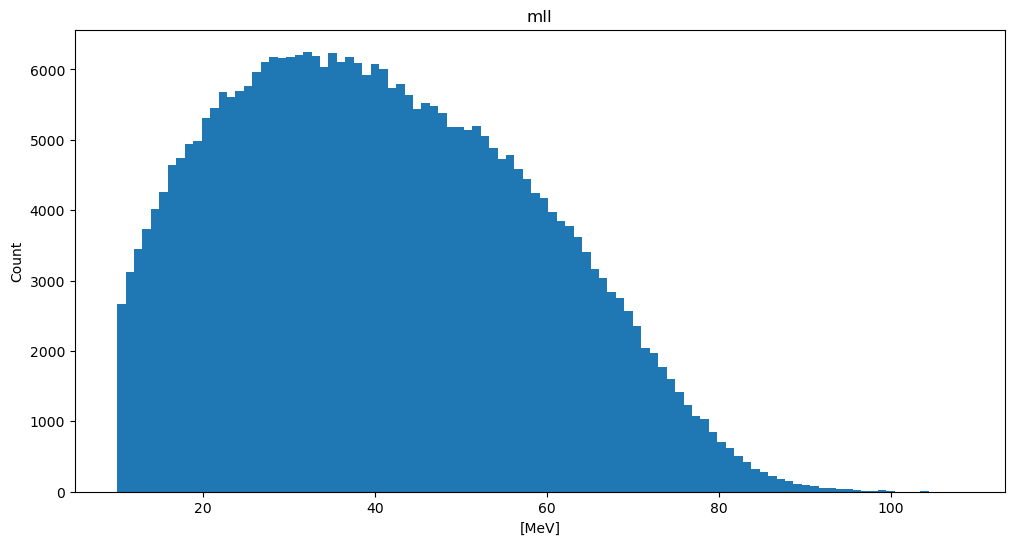

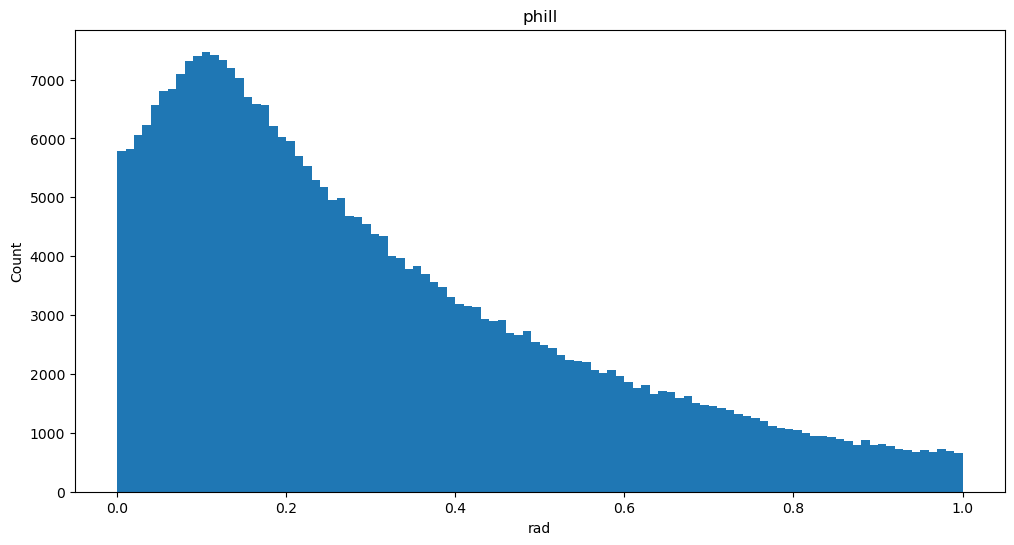

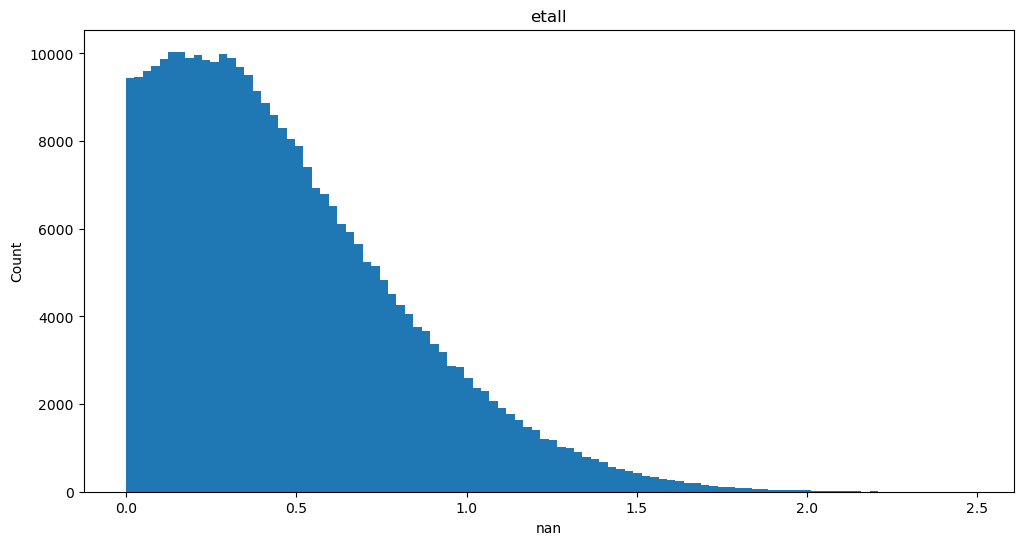

In [24]:
# check with paper

cut_pre_pt_lead = Truth_lead_lep.pt > 22  # 22 ~ 40 (SY)
print(len(Truth_lead_lep.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = Truth_sublead_lep.pt > 15
print(len(Truth_lead_lep.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(Truth_lead_lep.energy + Truth_sublead_lep.energy)
        - np.square(Truth_lead_lep.px + Truth_sublead_lep.px)
        - np.square(Truth_lead_lep.py + Truth_sublead_lep.py)
        - np.square(Truth_lead_lep.pz + Truth_sublead_lep.pz)
    )
    > 10
)
print(len(Truth_lead_lep.energy) - np.sum(cut_pre_dilep_m * 1))
met = Truth_lead_nu.p4 + Truth_sublead_nu.p4
cut_pre_pt_miss = pt(met[:, 0], met[:, 1]) > 20
print(len(Truth_lead_lep.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(Truth_lead_lep.energy) - np.sum(PRE_CUT * 1))
tl_mask = ~np.isnan(Truth_dilep().m)
print("Time-like ratio:", np.sum(tl_mask) / len(tl_mask))
mask = PRE_CUT & tl_mask

mll = Truth_dilep().m[mask]
phill = Truth_dilep().dphi[mask]
etall = Truth_dilep().deta[mask]

test_plot(mll, "mll")
test_plot(phill, "phill", xlabel="rad")
test_plot(etall, "etall", xlabel="nan")

The length of the data is: 375170


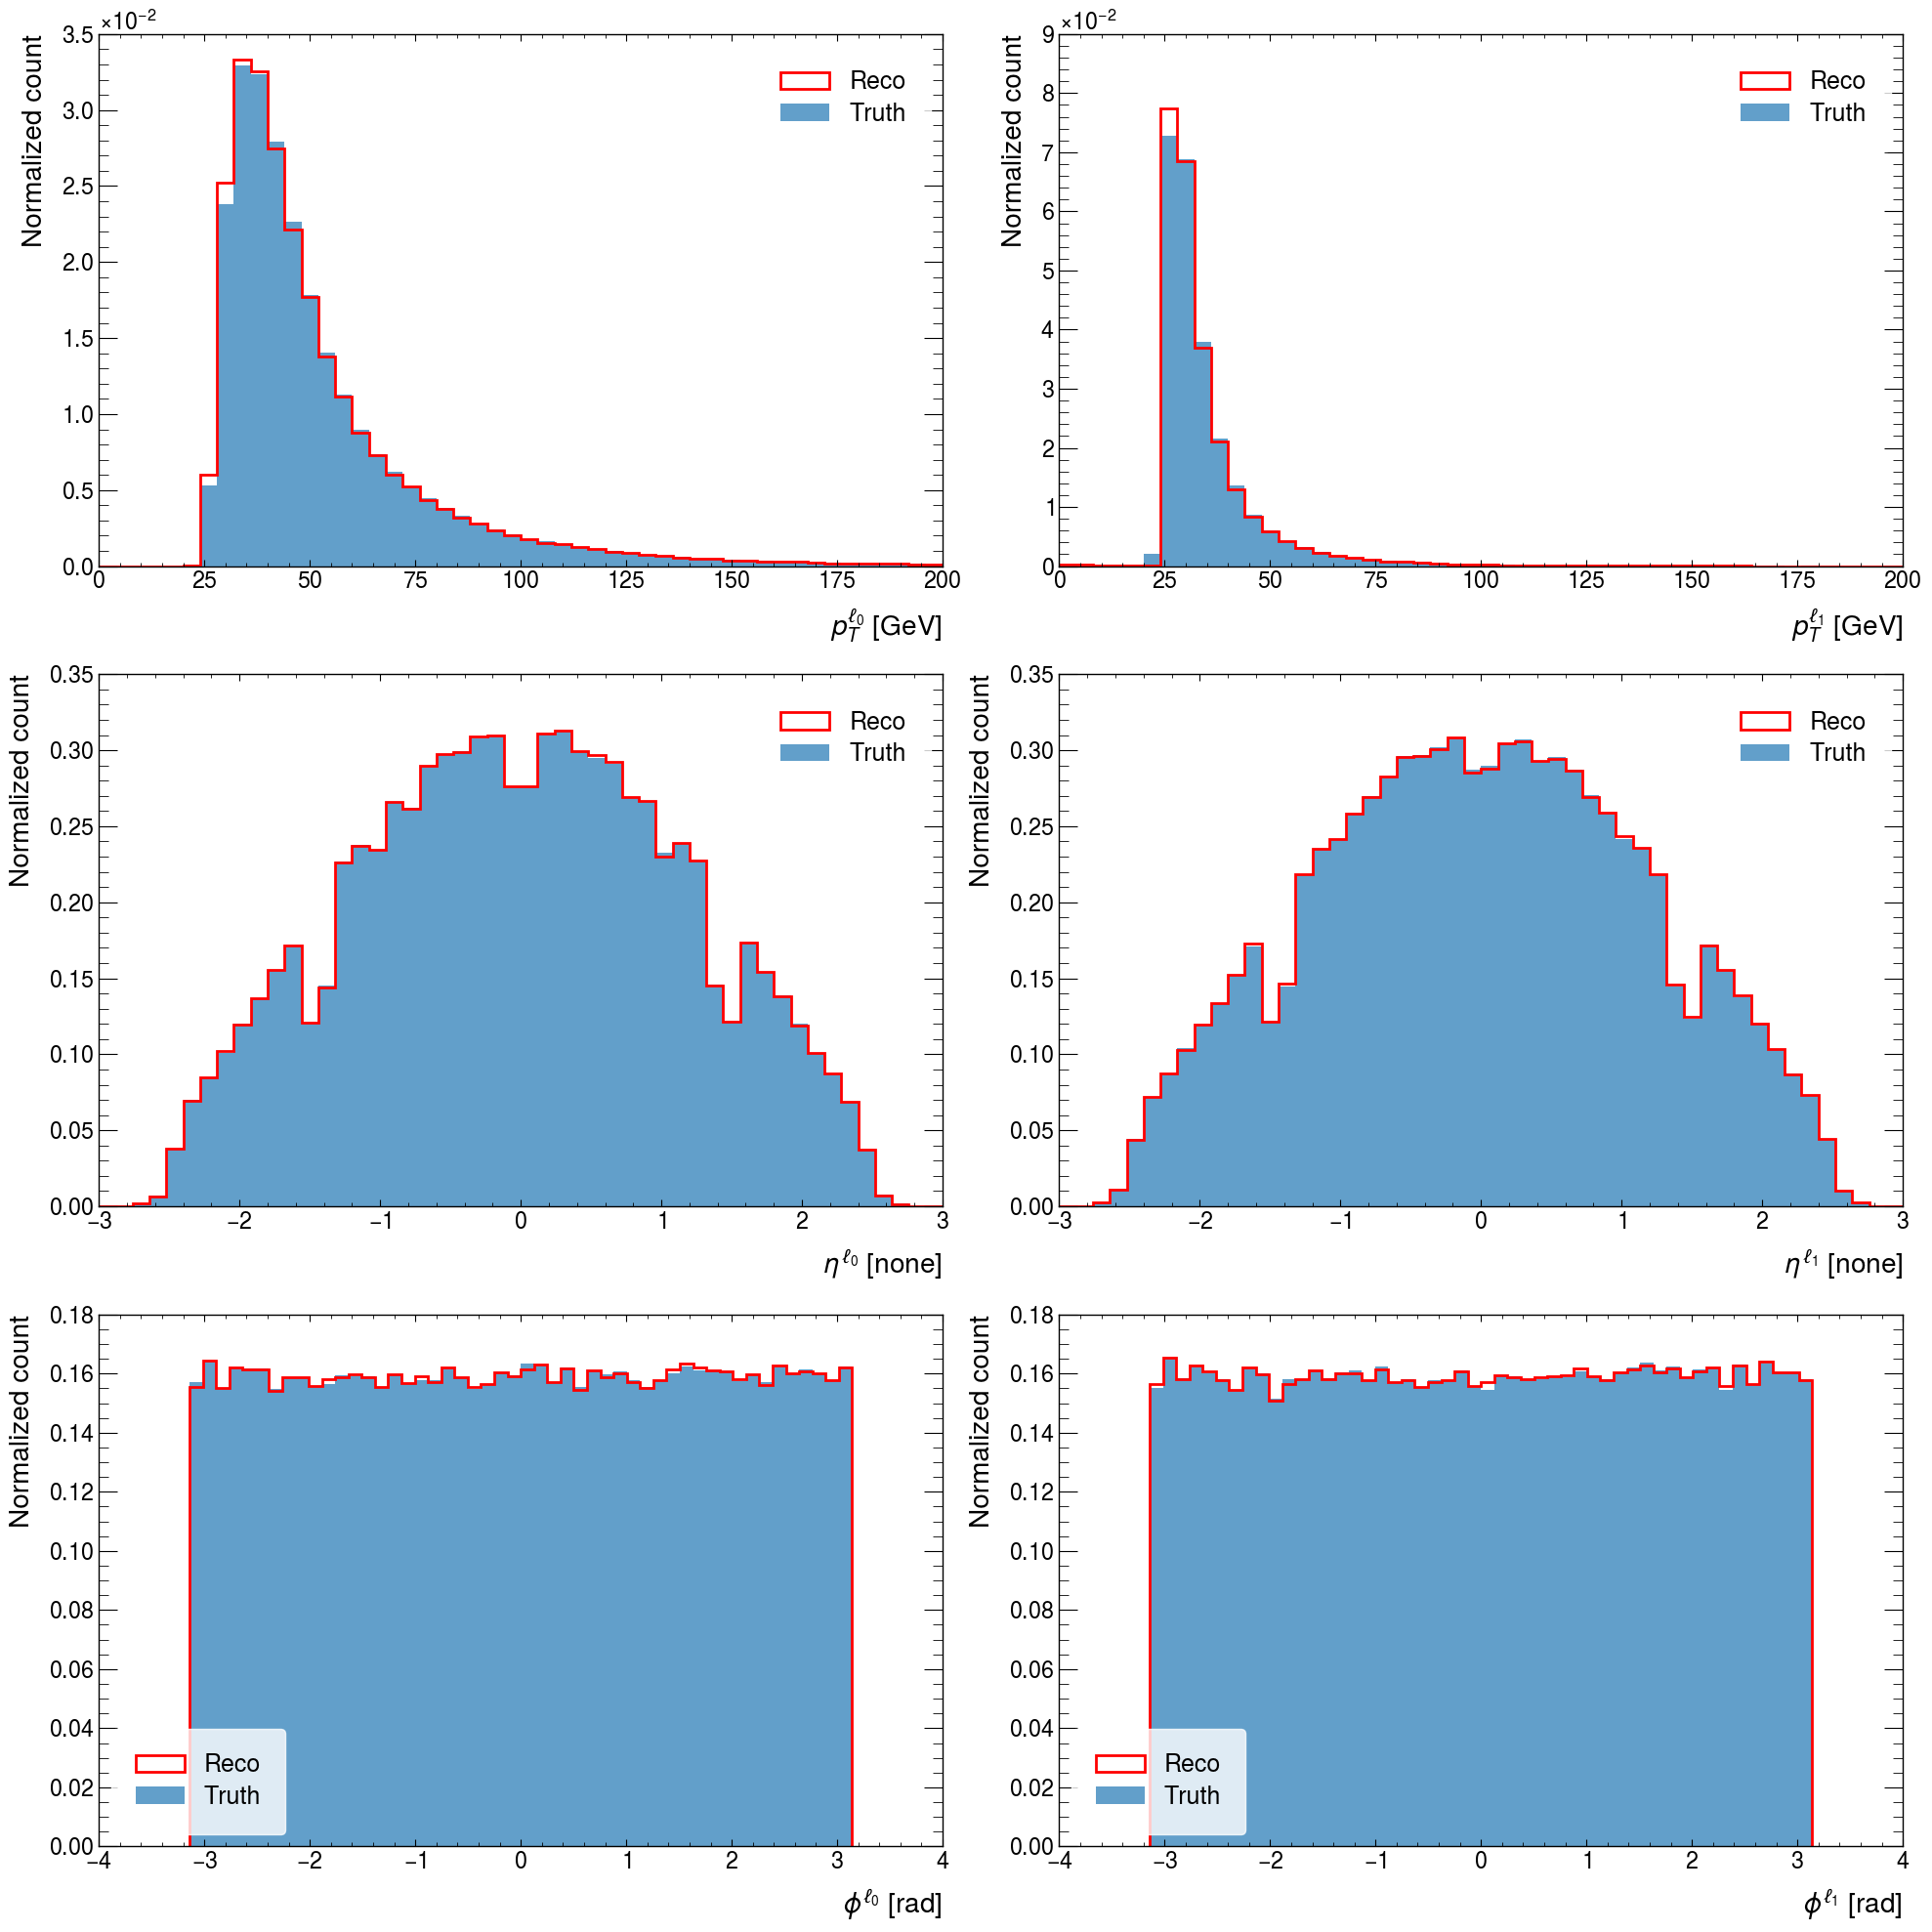

In [25]:
import mplhep as hep

hep.style.use("ATLAS")

print("The length of the data is:", len(Lead_lep.pt))

# Create a figure withbplots
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
# PT comparisons
bins_edges = np.linspace(0, 200, 51)
axs[0, 0].hist(Lead_lep.pt, bins=bins_edges, histtype="step", linewidth=2, color="red", label='Reco', density=True)
axs[0, 0].hist(Truth_lead_lep.pt, bins=bins_edges, histtype="bar", color="tab:blue", alpha=.7, label='Truth', density=True)
axs[0, 0].set_xlabel(r'$p^{\ell_0}_{T}$ [GeV]')
axs[0, 0].set_ylabel('Normalized count')
axs[0, 0].legend(loc="best", fontsize=18, frameon=True, facecolor='white', edgecolor='white')

axs[0, 1].hist(Sublead_lep.pt, bins=bins_edges, histtype="step", linewidth=2, color="red", label='Reco', density=True)
axs[0, 1].hist(Truth_sublead_lep.pt, bins=bins_edges, histtype="bar", color="tab:blue", alpha=.7, label='Truth', density=True)
axs[0, 1].set_xlabel(r'$p^{\ell_1}_{T}$ [GeV]')
axs[0, 1].set_ylabel('Normalized count')
axs[0, 1].legend(loc="best", fontsize=18, frameon=True, facecolor='white', edgecolor='white')

# Eta comparisons
bins_edges = np.linspace(-3, 3, 51)
axs[1, 0].hist(Lead_lep.eta, bins=bins_edges, histtype="step", linewidth=2, color="red", label='Reco', density=True)
axs[1, 0].hist(Truth_lead_lep.eta, bins=bins_edges, histtype="bar", color="tab:blue", alpha=.7, label='Truth', density=True)
axs[1, 0].set_xlabel(r'$\eta^{\ell_0}$ [none]')
axs[1, 0].set_ylabel('Normalized count')
axs[1, 0].legend(loc="best", fontsize=18, frameon=True, facecolor='white', edgecolor='white')

axs[1, 1].hist(Sublead_lep.eta, bins=bins_edges, histtype="step", linewidth=2, color="red", label='Reco', density=True)
axs[1, 1].hist(Truth_sublead_lep.eta, bins=bins_edges, histtype="bar", color="tab:blue", alpha=.7, label='Truth', density=True)
axs[1, 1].set_xlabel(r'$\eta^{\ell_1}$ [none]')
axs[1, 1].set_ylabel('Normalized count')
axs[1, 1].legend(loc="best", fontsize=18, frameon=True, facecolor='white', edgecolor='white')

# Phi comparisons
bins_edges = np.linspace(-np.pi, np.pi, 51)
axs[2, 0].hist(Lead_lep.phi, bins=bins_edges, histtype="step", linewidth=2, color="red", label='Reco', density=True)
axs[2, 0].hist(Truth_lead_lep.phi, bins=bins_edges, histtype="bar", color="tab:blue", alpha=.7, label='Truth', density=True)
axs[2, 0].set_xlabel(r'$\phi^{\ell_0}$ [rad]')
axs[2, 0].set_ylabel('Normalized count')
axs[2, 0].legend(loc="best", fontsize=18, frameon=True, facecolor='white', edgecolor='white')

axs[2, 1].hist(Sublead_lep.phi, bins=bins_edges, histtype="step", linewidth=2, color="red", label='Reco', density=True)
axs[2, 1].hist(Truth_sublead_lep.phi, bins=bins_edges, histtype="bar", color="tab:blue", alpha=.7, label='Truth', density=True)
axs[2, 1].set_xlabel(r'$\phi^{\ell_1}$ [rad]')
axs[2, 1].set_ylabel('Normalized count')
axs[2, 1].legend(loc="best", fontsize=18, frameon=True, facecolor='white', edgecolor='white')

plt.tight_layout()
plt.show()

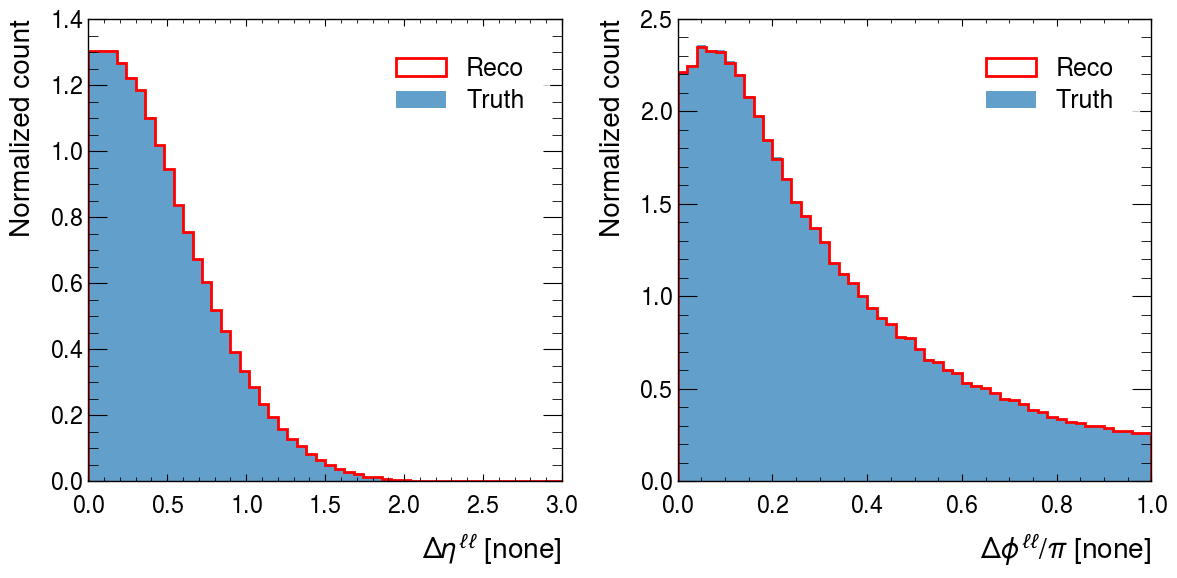

In [26]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Dilepton deta comparison
bins_edges = np.linspace(0, 3, 51)  # Adjust the range as needed
axs[0].hist(Dilep.deta, bins=bins_edges, histtype="step", linewidth=2, color="red", label='Reco', density=True)
axs[0].hist(Truth_dilep.deta, bins=bins_edges, histtype="bar", color="tab:blue", alpha=.7, label='Truth', density=True)
axs[0].set_xlabel(r'$\Delta\eta^{\ell\ell}$ [none]')
axs[0].set_ylabel('Normalized count')
axs[0].legend(loc="best", fontsize=18, frameon=True, facecolor='white', edgecolor='white')
# Add padding to x-ticks
axs[0].tick_params(axis='x', pad=10)  # Increase padding for x-tick labels

# Dilepton dphi comparison
bins_edges = np.linspace(0, 1, 51)  # dphi_pi returns values from 0 to 1
axs[1].hist(Dilep.dphi, bins=bins_edges, histtype="step", linewidth=2, color="red", label='Reco', density=True)
axs[1].hist(Truth_dilep.dphi, bins=bins_edges, histtype="bar", color="tab:blue", alpha=.7, label='Truth', density=True)
axs[1].set_xlabel(r'$\Delta\phi^{\ell\ell}/\pi$ [none]')
axs[1].set_ylabel('Normalized count')
axs[1].legend(loc="best", fontsize=18, frameon=True, facecolor='white', edgecolor='white')
# Add padding to x-ticks
axs[1].tick_params(axis='x', pad=10)  # Increase padding for x-tick labels

plt.tight_layout()
plt.show()

35681
128575
8387
50066
173433
Time-like ratio: 1.0


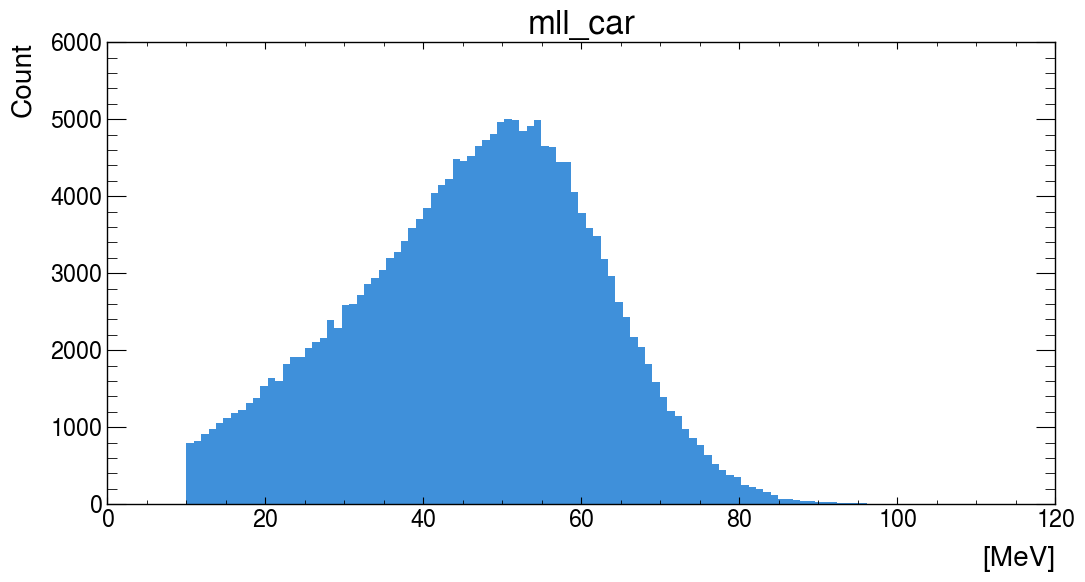

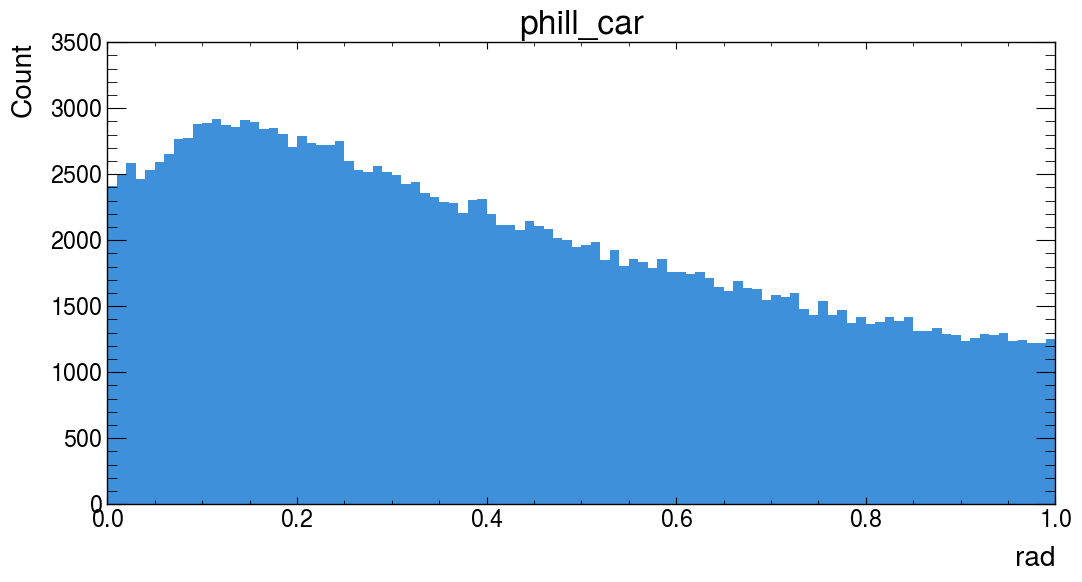

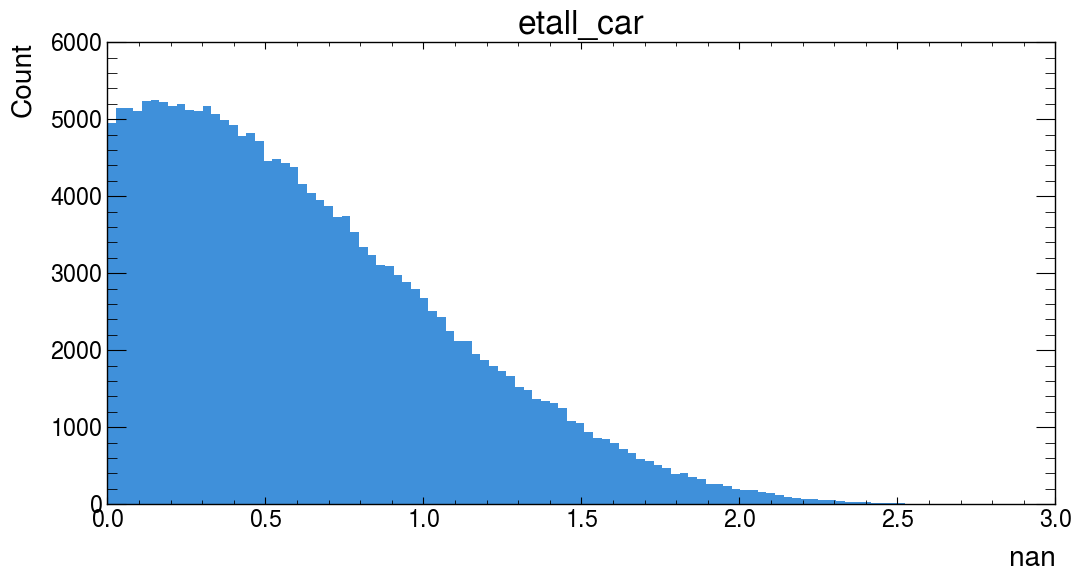

In [27]:
# check with paper
cut_pre_pt_lead = Truth_lead_lep_CAR.pt > 22  # 22 ~ 40 (SY)
print(len(Truth_lead_lep_CAR.energy) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = Truth_sublead_lep_CAR.pt > 15
print(len(Truth_lead_lep_CAR.energy) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.sqrt(
        np.square(Truth_lead_lep_CAR.energy + Truth_sublead_lep_CAR.energy)
        - np.square(Truth_lead_lep_CAR.px + Truth_sublead_lep_CAR.px)
        - np.square(Truth_lead_lep_CAR.py + Truth_sublead_lep_CAR.py)
        - np.square(Truth_lead_lep_CAR.pz + Truth_sublead_lep_CAR.pz)
    )
    > 10
)
print(len(Truth_lead_lep_CAR.energy) - np.sum(cut_pre_dilep_m * 1))
met = Truth_lead_nu_CAR.p4 + Truth_sublead_nu_CAR.p4
cut_pre_pt_miss = pt(met[:, 0], met[:, 1]) > 20
print(len(Truth_lead_lep_CAR.energy) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print(len(Truth_lead_lep_CAR.energy) - np.sum(PRE_CUT * 1))
tl_mask_car = ~np.isnan(Truth_dilep_CAR().m)
mask_car = PRE_CUT & tl_mask_car
print("Time-like ratio:", np.sum(tl_mask_car) / len(tl_mask_car))

mll_car = Truth_dilep_CAR.m[mask_car]
phill_car = Truth_dilep_CAR.dphi[mask_car]
etall_car = Truth_dilep_CAR.deta[mask_car]
test_plot(mll_car, "mll_car")
test_plot(phill_car, "phill_car", xlabel="rad")
test_plot(etall_car, "etall_car", xlabel="nan")

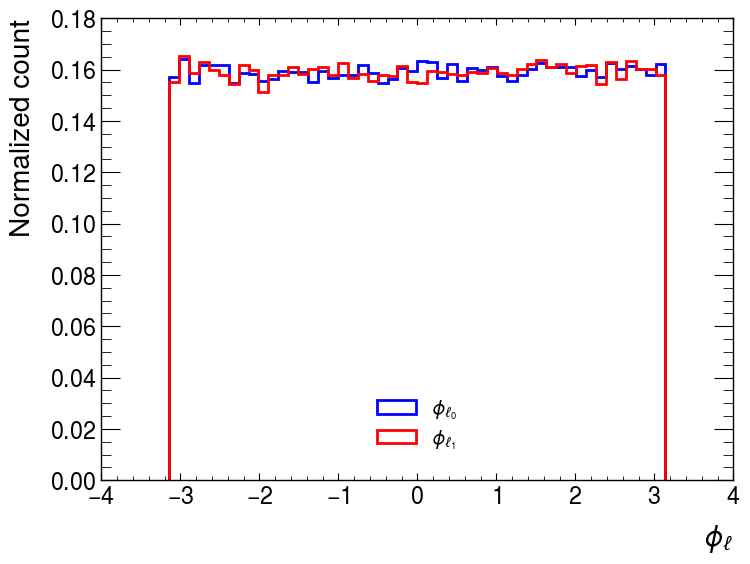

In [28]:
fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(-np.pi, np.pi, 51)
plt.hist(
    Truth_lead_lep().phi,
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    label=r"$\phi_{\ell_0}$",
    density=True,
)
plt.hist(
    Truth_sublead_lep().phi,
	bins=bins_edge,
	histtype="step",
	color="red",
	linewidth=2,
	label=r"$\phi_{\ell_1}$",
	density=True,
)
plt.legend(loc="best")
plt.xlabel(r"$\phi_{\ell}$")
plt.ylabel("Normalized count")
plt.show()

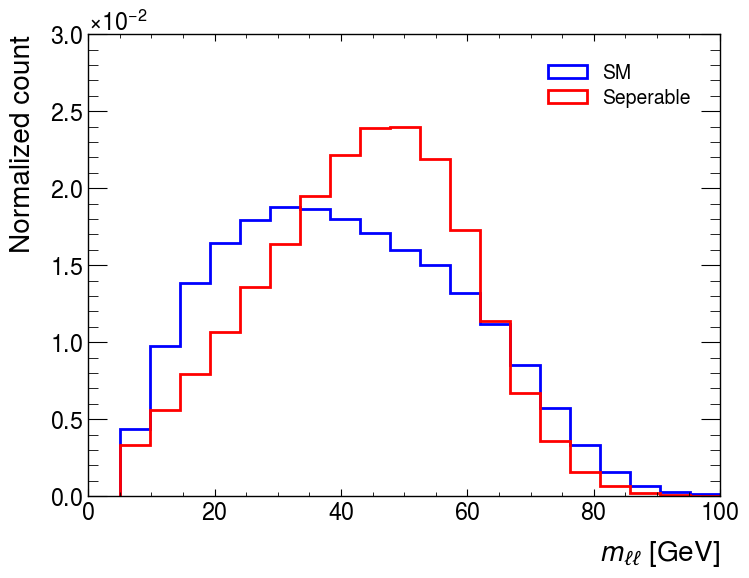

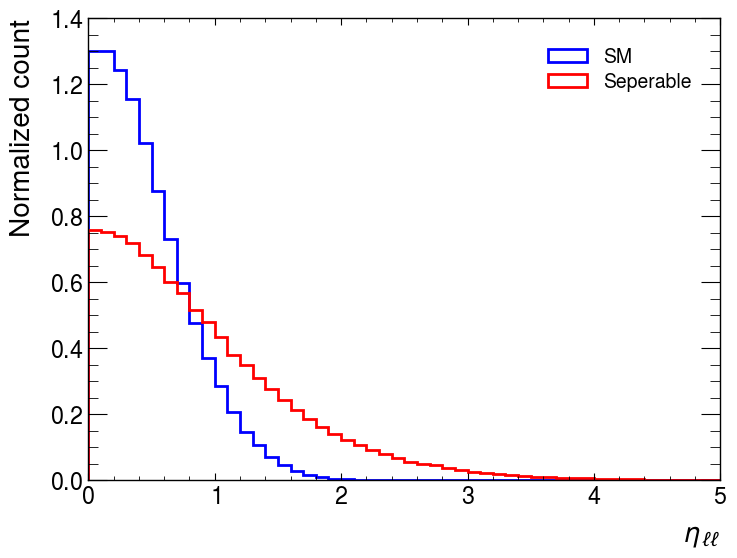

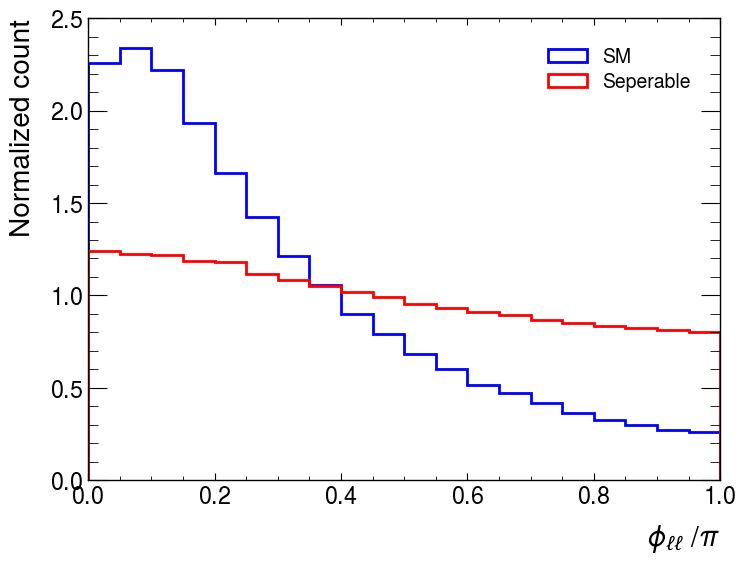

In [29]:
fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(5, 100, 21)
plt.hist(
    Truth_dilep().m,
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    label="SM",
    density=True,
)
plt.hist(
    Truth_dilep_CAR().m,
    bins=bins_edge,
    histtype="step",
    color="red",
    linewidth=2,
    label="Seperable",
    density=True,
)
plt.legend(loc="best")
plt.xlabel(r"$m_{\ell \ell}$ [GeV]")
plt.ylabel("Normalized count")
plt.show()

fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(0, 5, 51)
plt.hist(
    Truth_dilep().deta,
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    label="SM",
    density=True,
)
plt.hist(
    Truth_dilep_CAR().deta,
    bins=bins_edge,
    histtype="step",
    color="red",
    linewidth=2,
    label="Seperable",
    density=True,
)
plt.legend(loc="best")
plt.xlabel(r"$\eta_{\ell \ell}$")
plt.ylabel("Normalized count")
plt.show()

fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(0, 1, 21)
plt.hist(
    Truth_dilep().dphi,
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    label="SM",
    density=True,
)
plt.hist(
    Truth_dilep_CAR().dphi,
    bins=bins_edge,
    histtype="step",
    color="red",
    linewidth=2,
    label="Seperable",
    density=True,
)
plt.legend(loc="best")
plt.xlabel(r"$\phi_{\ell \ell}\ / \pi$")
plt.ylabel("Normalized count")
plt.show()

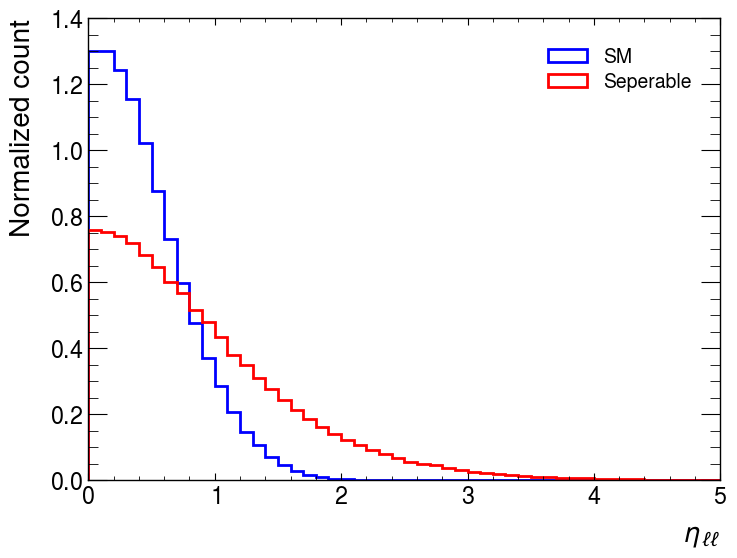

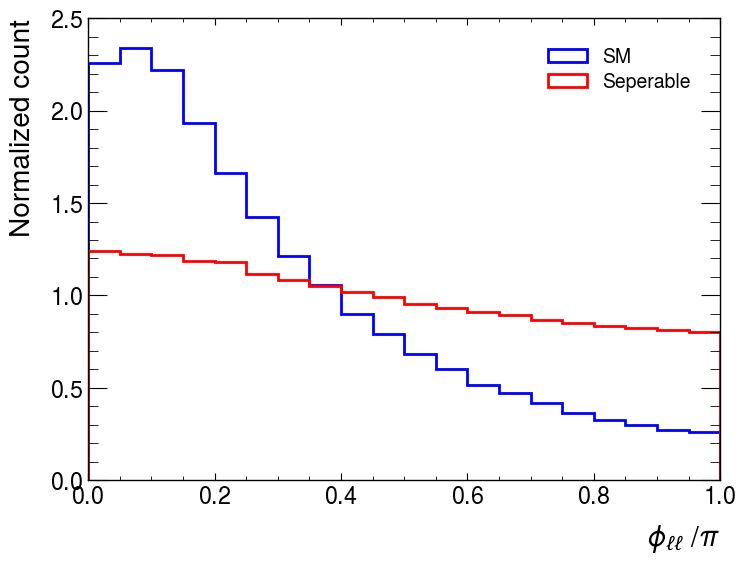

In [30]:
# selected with effective events and preselections
detall_charge = deta(truth_lep_pos_eta, truth_lep_neg_eta)
dphi_charge = dphi_pi(truth_lep_pos_phi, truth_lep_neg_phi)
detall_charge_car = deta(truth_lep_pos_car_eta, truth_lep_neg_car_eta)
dphi_charge_car = dphi_pi(truth_lep_pos_car_phi, truth_lep_neg_car_phi)

fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(0, 5, 51)
plt.hist(
    detall_charge,
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    label="SM",
    density=True,
)
plt.hist(
    detall_charge_car,
    bins=bins_edge,
    histtype="step",
    color="red",
    linewidth=2,
    label="Seperable",
    density=True,
)
plt.legend(loc="best")
plt.xlabel(r"$\eta_{\ell \ell}$")
plt.ylabel("Normalized count")
plt.show()

fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(0, 1, 21)
plt.hist(
    dphi_charge,
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    label="SM",
    density=True,
)
plt.hist(
    dphi_charge_car,
    bins=bins_edge,
    histtype="step",
    color="red",
    linewidth=2,
    label="Seperable",
    density=True,
)
plt.legend(loc="best")
plt.xlabel(r"$\phi_{\ell \ell}\ / \pi$")
plt.ylabel("Normalized count")
plt.show()

In [39]:
import h5py
import numpy as np
from dataclasses import fields, is_dataclass

def save_dataclasses_to_h5(filename, **dataclasses_dict):
    """
    Save dataclasses to an HDF5 file
    
    Args:
        filename: Path to the output HDF5 file
        **dataclasses_dict: Keyword arguments with names and dataclass instances
    """
    with h5py.File(filename, 'w') as f:
        # For each dataclass
        for group_name, dataclass_instance in dataclasses_dict.items():
            # Create a group for this dataclass
            group = f.create_group(group_name)
            
            # Get all attributes that aren't special methods
            for attr_name in dir(dataclass_instance):
                if not attr_name.startswith('_'):  # Skip private attributes
                    try:
                        attr_value = getattr(dataclass_instance, attr_name)
                        
                        # Handle numpy arrays
                        if isinstance(attr_value, np.ndarray):
                            group.create_dataset(attr_name, data=attr_value, compression="gzip")
                        # Handle scalars
                        elif np.isscalar(attr_value):
                            group.attrs[attr_name] = attr_value
                    except Exception as e:
                        print(f"Error saving {group_name}.{attr_name}: {e}")

# Usage example - add this at the end of your file
if __name__ == "__main__":
    # Import required libraries at the top of your file
    import numpy as np
    from dataclasses import dataclass
    import h5py
    
    # After your dataclass definitions and initializations
    
    def save_particles_to_h5(filename="mc20_recotruth.h5"):
        """Save all particle dataclasses to H5 file"""
        save_dataclasses_to_h5(
            filename,
            lead_lep=Lead_lep,
            sublead_lep=Sublead_lep,
            dilep=Dilep,
            met=Met,
            truth_lead_lep=Truth_lead_lep,
            truth_sublead_lep=Truth_sublead_lep,
            truth_dilep=Truth_dilep,
            truth_lead_nu=Truth_lead_nu,
            truth_sublead_nu=Truth_sublead_nu,
            truth_lead_lep_car=Truth_lead_lep_CAR,
            truth_sublead_lep_car=Truth_sublead_lep_CAR,
            truth_dilep_car=Truth_dilep_CAR,
            truth_lead_nu_car=Truth_lead_nu_CAR,
            truth_sublead_nu_car=Truth_sublead_nu_CAR,
            lead_w=Lead_w,
            sublead_w=Sublead_w,
            higgs=Higgs
        )
        print(f"Successfully saved particle data to {filename}")
    
    # Call the function to save the data
    save_particles_to_h5()

Successfully saved particle data to mc20_recotruth.h5


In [40]:
def load_particles_from_h5(filename="mc20_recotruth.h5"):
    """
    Load particle data from an HDF5 file
    
    Args:
        filename: Path to the HDF5 file
        
    Returns:
        Dictionary with the loaded data
    """
    result = {}
    
    with h5py.File(filename, 'r') as f:
        # For each group in the file
        for group_name in f.keys():
            group_data = {}
            
            # Load datasets (numpy arrays)
            for dataset_name in f[group_name].keys():
                group_data[dataset_name] = f[group_name][dataset_name][:]
            
            # Load attributes (scalars)
            for attr_name, attr_value in f[group_name].attrs.items():
                group_data[attr_name] = attr_value
            
            result[group_name] = group_data
            
    return result

In [41]:
load_particles_from_h5().keys()

dict_keys(['dilep', 'higgs', 'lead_lep', 'lead_w', 'met', 'sublead_lep', 'sublead_w', 'truth_dilep', 'truth_dilep_car', 'truth_lead_lep', 'truth_lead_lep_car', 'truth_lead_nu', 'truth_lead_nu_car', 'truth_sublead_lep', 'truth_sublead_lep_car', 'truth_sublead_nu', 'truth_sublead_nu_car'])